In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

MIN_LENGTH = 100_000

# Load embeddings (col 0 = length, cols 1-384 = embeddings)
data = np.load('Runs/embeddings_SFE_SE_1.npy')
all_lengths = data[:, 0]
long_mask = all_lengths >= MIN_LENGTH
print(f'Total sequences: {len(all_lengths):,}')
print(f'Sequences >= {MIN_LENGTH:,} bp: {long_mask.sum():,} ({100 * long_mask.mean():.1f}%)')

lengths = all_lengths[long_mask]
embeddings = data[long_mask, 1:]
del data, all_lengths
print(f'Loaded {embeddings.shape[0]:,} embeddings with {embeddings.shape[1]} dimensions')
print(f'Length range: {lengths.min():.0f} - {lengths.max():.0f}')

# Pre-compute L2-normalized embeddings for cosine distance via dot product
norms = np.linalg.norm(embeddings, axis = 1, keepdims = True)
embeddings_normed = embeddings / norms
del norms

# Load embedding IDs (filter to same mask)
all_ids = np.loadtxt('Runs/ids_SFE_SE_1.txt', dtype = str)
embedding_ids = all_ids[long_mask]
del all_ids
print(f'Loaded {embedding_ids.shape[0]:,} embedding IDs')

# Load k-mer frequencies (col 0 = length, cols 1-2772 = k-mers)
kmers = np.load('Runs/kmers_SFE_SE_1.npy')[long_mask]
print(f'Loaded k-mer data: {kmers.shape}')

del long_mask

# Extract k-mer frequencies by size (new format without 7-mers)
six_mers = kmers[:, 1:2081]        # 2080 features
five_mers = kmers[:, 2081:2593]    # 512 features
four_mers = kmers[:, 2593:2729]    # 136 features
three_mers = kmers[:, 2729:2761]   # 32 features
two_mers = kmers[:, 2761:2771]     # 10 features
one_mers = kmers[:, 2771:2773]     # 2 features

print(f'6-mers: {six_mers.shape[1]} features')
print(f'5-mers: {five_mers.shape[1]} features')
print(f'4-mers: {four_mers.shape[1]} features')
print(f'3-mers: {three_mers.shape[1]} features')
print(f'2-mers: {two_mers.shape[1]} features')
print(f'1-mers: {one_mers.shape[1]} features')

Total sequences: 6,693,829
Sequences >= 100,000 bp: 154,040 (2.3%)
Loaded 154,040 embeddings with 384 dimensions
Length range: 100000 - 10208085
Loaded 154,040 embedding IDs
Loaded k-mer data: (154040, 2773)
6-mers: 2080 features
5-mers: 512 features
4-mers: 136 features
3-mers: 32 features
2-mers: 10 features
1-mers: 2 features



Number of pairwise distances: 49,995,000
Distance range: 0.05 - 42.22
Mean: 11.75, Std: 2.01


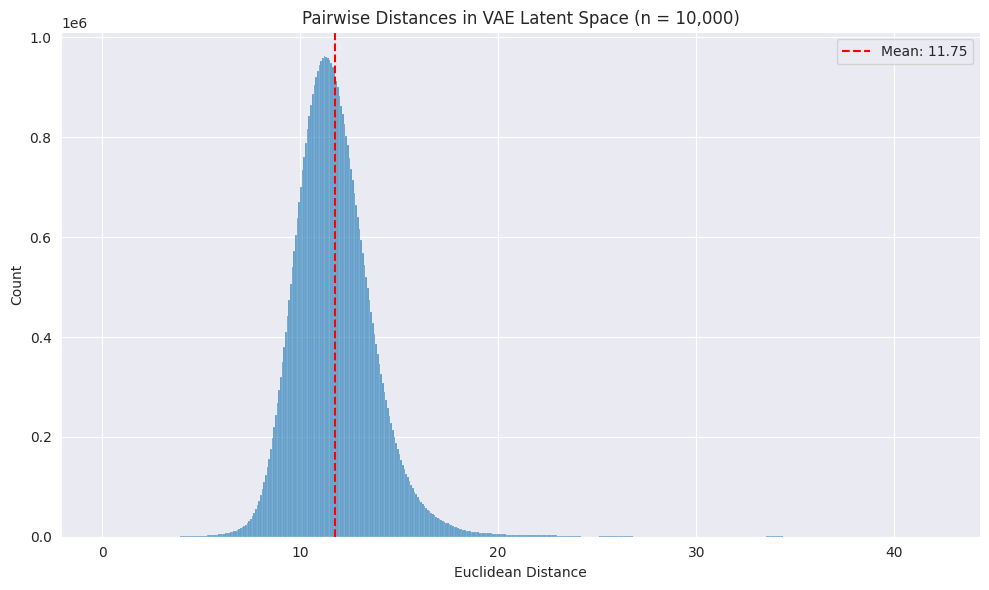

In [5]:
# Randomly sample 10,000 entries
rng = np.random.default_rng(42)
idx = rng.choice(len(embeddings), size = 10_000, replace = False)
sample = embeddings[idx]

# Calculate pairwise Euclidean distances (float32 via squared-distance decomposition)
sq_norms = np.einsum('ij,ij->i', sample, sample)
sq_dists = sq_norms[:, None] + sq_norms[None, :] - 2 * (sample @ sample.T)
np.maximum(sq_dists, 0, out = sq_dists)  # Clamp numerical noise
np.fill_diagonal(sq_dists, 0)
# Extract upper triangle (same as pdist output)
distances = np.sqrt(sq_dists[np.triu_indices(len(sample), k = 1)])

print(f'\nNumber of pairwise distances: {len(distances):,}')
print(f'Distance range: {distances.min():.2f} - {distances.max():.2f}')
print(f'Mean: {distances.mean():.2f}, Std: {distances.std():.2f}')

# Plot histogram
fig, ax = plt.subplots(figsize = (10, 6))
sns.histplot(distances, bins = 500, alpha = 0.7, ax = ax)
ax.axvline(distances.mean(), color = 'red', linestyle = '--', label = f'Mean: {distances.mean():.2f}')
ax.set_xlabel('Euclidean Distance')
ax.set_ylabel('Count')
ax.set_title('Pairwise Distances in VAE Latent Space (n = 10,000)')
ax.legend()
plt.tight_layout()
plt.show()
del sq_norms, sq_dists

Number of pairwise distances: 49,995,000
Distance range: 0.0000 - 1.4338
Mean: 0.9910, Std: 0.0961


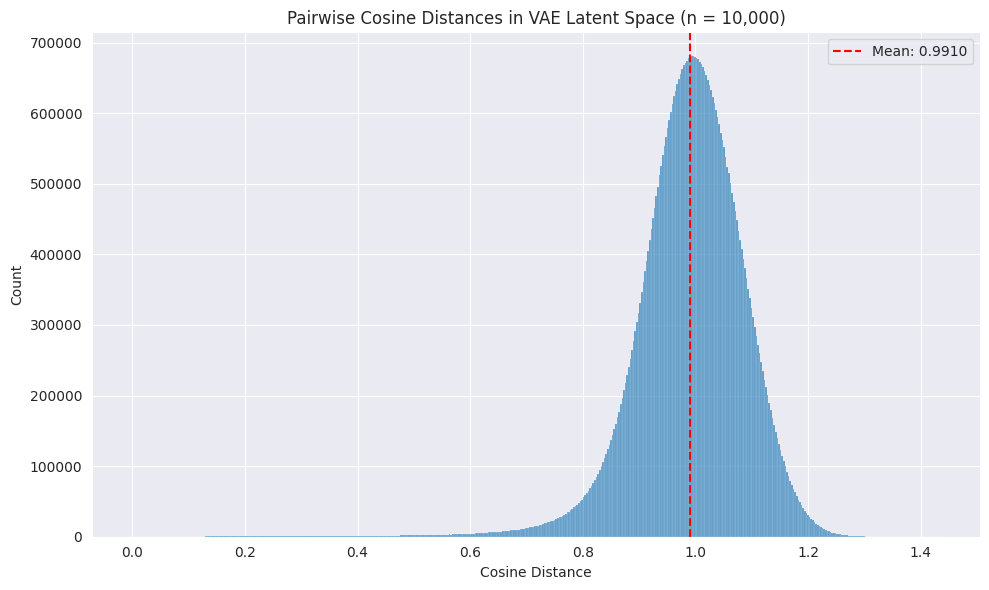

In [6]:
# Calculate pairwise cosine distances (using same sample, float32 via dot product)
sample_norms = np.linalg.norm(sample, axis = 1, keepdims = True)
sample_normed = sample / sample_norms
cos_sims = sample_normed @ sample_normed.T
np.clip(cos_sims, -1, 1, out = cos_sims)
cos_dists = 1 - cos_sims
cosine_distances = cos_dists[np.triu_indices(len(sample), k = 1)]

print(f'Number of pairwise distances: {len(cosine_distances):,}')
print(f'Distance range: {cosine_distances.min():.4f} - {cosine_distances.max():.4f}')
print(f'Mean: {cosine_distances.mean():.4f}, Std: {cosine_distances.std():.4f}')

# Plot histogram
fig, ax = plt.subplots(figsize = (10, 6))
sns.histplot(cosine_distances, bins = 500, alpha = 0.7, ax = ax)
ax.axvline(cosine_distances.mean(), color = 'red', linestyle = '--', label = f'Mean: {cosine_distances.mean():.4f}')
ax.set_xlabel('Cosine Distance')
ax.set_ylabel('Count')
ax.set_title('Pairwise Cosine Distances in VAE Latent Space (n = 10,000)')
ax.legend()
plt.tight_layout()
plt.show()
del sample_normed, cos_sims, cos_dists

Total 6-mer frequency values: 320,403,200
Range: 0.000000 - 0.234482
Mean: 0.000481, Std: 0.000464


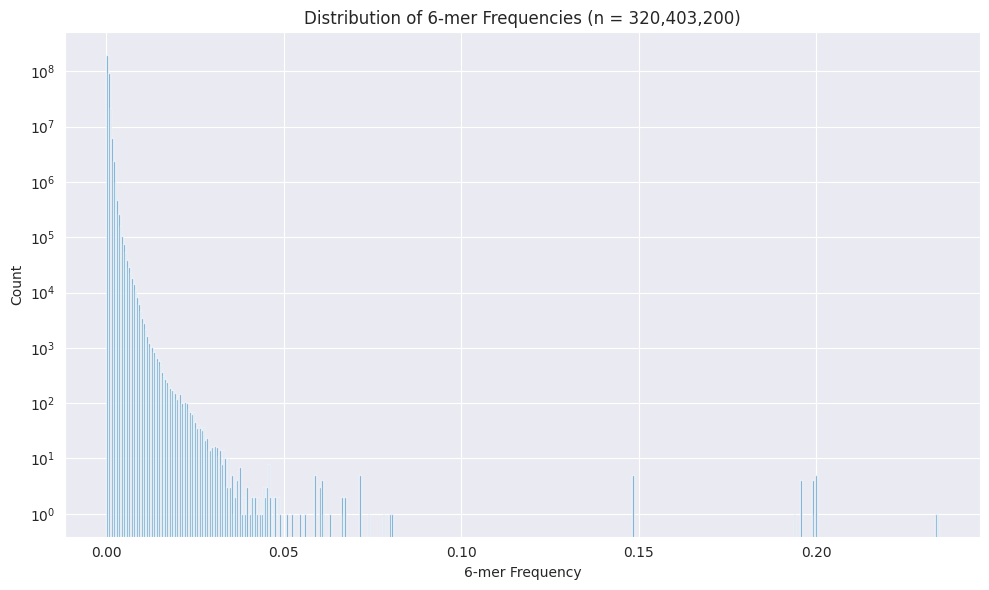

In [7]:
# Analyze 6-mer frequency distribution (using six_mers view, no flatten)
print(f'Total 6-mer frequency values: {six_mers.size:,}')
print(f'Range: {six_mers.min():.6f} - {six_mers.max():.6f}')
print(f'Mean: {six_mers.mean():.6f}, Std: {six_mers.std():.6f}')

# Compute histogram in chunks to avoid 56 GB flatten
bins = np.linspace(six_mers.min(), six_mers.max(), 501)
counts = np.zeros(len(bins) - 1, dtype = np.int64)
chunk_size = 100_000
for start in range(0, len(six_mers), chunk_size):
    chunk = six_mers[start:start + chunk_size].ravel()
    c, _ = np.histogram(chunk, bins = bins)
    counts += c

# Plot histogram
fig, ax = plt.subplots(figsize = (10, 6))
bin_widths = np.diff(bins)
ax.bar(bins[:-1], counts, width = bin_widths, alpha = 0.7, align = 'edge')
ax.set_yscale('log')
ax.set_xlabel('6-mer Frequency')
ax.set_ylabel('Count')
ax.set_title(f'Distribution of 6-mer Frequencies (n = {six_mers.size:,})')
plt.tight_layout()
plt.show()

In [ ]:
## Analyze 6-mer frequency distribution
## How many 6-mers occur less than 1% of the time
#threshold = 0.01
#rare_counts = np.sum(six_mers < threshold, axis = 1)
#
#print(f'6-mer rarity analysis (threshold: {threshold * 100:.0f}%)')
#print(f'Total 6-mers per sequence: {six_mers.shape[1]}')
#print(f'Rare 6-mers per sequence (< {threshold * 100:.0f}%):')
#print(f'  Mean: {rare_counts.mean():.1f}')
#print(f'  Min: {rare_counts.min()}')
#print(f'  Max: {rare_counts.max()}')
#print(f'  Median: {np.median(rare_counts):.0f}')
#
## Plot histogram
#fig, ax = plt.subplots(figsize = (10, 6))
#sns.histplot(rare_counts, bins = 100, alpha = 0.7, ax = ax)
#ax.axvline(rare_counts.mean(), color = 'red', linestyle = '--', label = f'Mean: {rare_counts.mean():.1f}')
#ax.set_xlabel(f'Number of 6-mers with frequency < {threshold * 100:.0f}%')
#ax.set_ylabel('Count (sequences)')
#ax.set_title(f'Distribution of Rare 6-mer Counts (n = {len(rare_counts):,})')
#ax.legend()
#plt.tight_layout()
#plt.show()

Sampled 100,000 sequences
Sequences with at least one neighbor within 5.0 Euclidean distance: 77,901 (77.90%)
Minimum distance found: 0.0396
Mean nearest neighbor distance: 3.8265


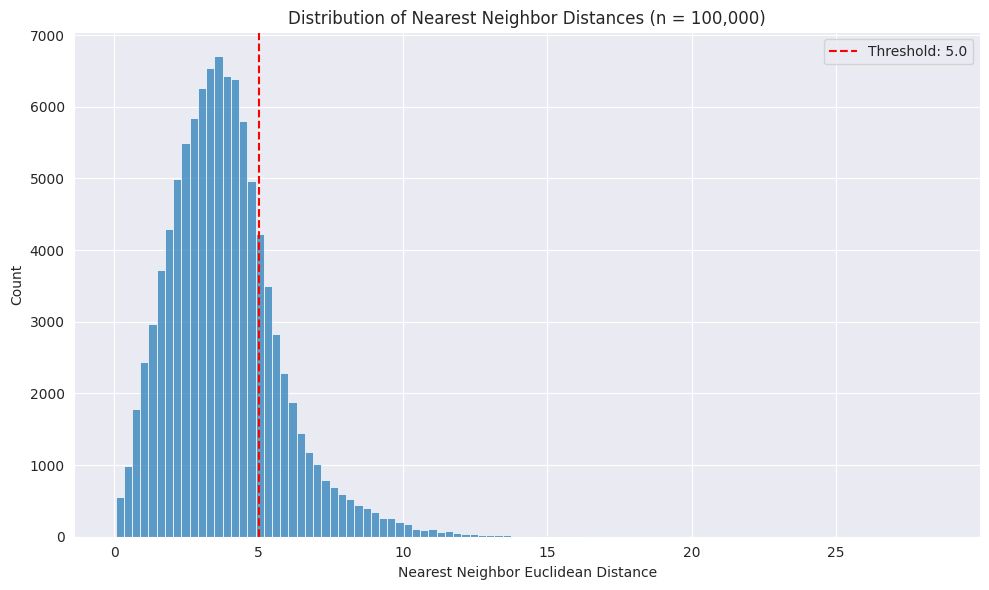

In [8]:
# Sample 100,000 sequences and check for close neighbors (float32 Euclidean)
sample_size = 100_000
neighbor_threshold = 5.0

rng_sample = np.random.default_rng(123)
sample_idx = rng_sample.choice(len(embeddings), size = sample_size, replace = False)
sample_embeddings = embeddings[sample_idx]

# Pre-compute squared norms for ||a-b||² = ||a||² + ||b||² - 2·a·b
sq_norms = np.einsum('ij,ij->i', sample_embeddings, sample_embeddings)

# Compute nearest-neighbor distances in chunks (~2 GB per chunk in float32)
min_distances = np.full(sample_size, np.inf, dtype = np.float32)
chunk_size = 5_000
for start in range(0, sample_size, chunk_size):
    end = min(start + chunk_size, sample_size)
    # Squared Euclidean distances
    sq_dists = sq_norms[start:end, None] + sq_norms[None, :] - 2 * (sample_embeddings[start:end] @ sample_embeddings.T)
    np.maximum(sq_dists, 0, out = sq_dists)
    # Set self-distances to inf
    for i in range(end - start):
        sq_dists[i, start + i] = np.inf
    min_distances[start:end] = np.sqrt(sq_dists.min(axis = 1))
    del sq_dists

has_close_neighbor = min_distances < neighbor_threshold

print(f'Sampled {sample_size:,} sequences')
print(f'Sequences with at least one neighbor within {neighbor_threshold} Euclidean distance: {has_close_neighbor.sum():,} ({100 * has_close_neighbor.mean():.2f}%)')
print(f'Minimum distance found: {min_distances.min():.4f}')
print(f'Mean nearest neighbor distance: {min_distances.mean():.4f}')

# Plot histogram of minimum distances
fig, ax = plt.subplots(figsize = (10, 6))
sns.histplot(min_distances, bins = 100, alpha = 0.7, ax = ax)
ax.axvline(neighbor_threshold, color = 'red', linestyle = '--', label = f'Threshold: {neighbor_threshold}')
ax.set_xlabel('Nearest Neighbor Euclidean Distance')
ax.set_ylabel('Count')
ax.set_title(f'Distribution of Nearest Neighbor Distances (n = {sample_size:,})')
ax.legend()
plt.tight_layout()
plt.show()

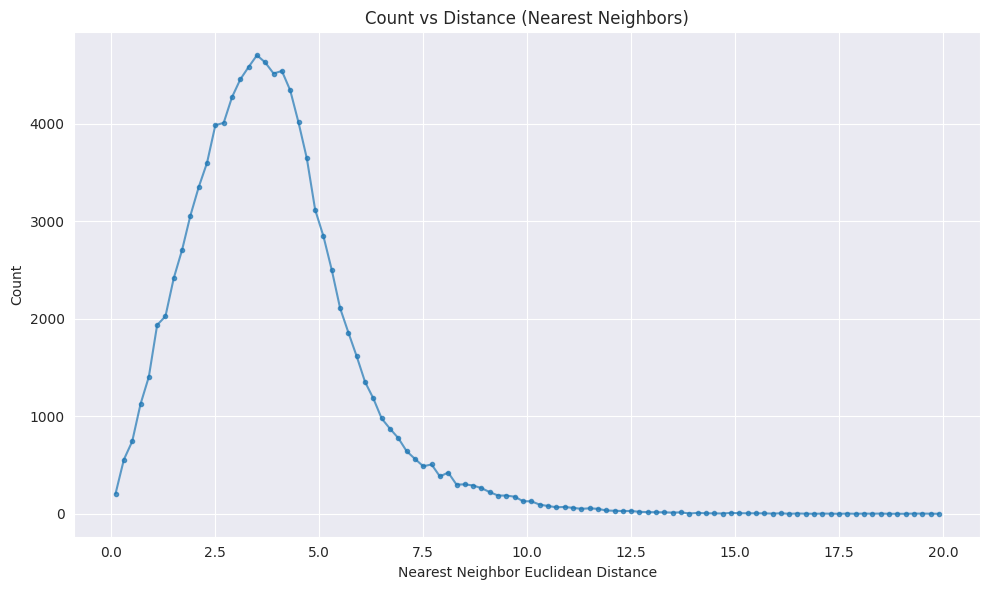

Linear fit: count = -185.2 * distance + 2852.4
R² = 0.5095


In [9]:
# Plot count vs distance (binned)
max_dist = 20.0
bins = np.linspace(0, max_dist, 101)
bin_centers = (bins[:-1] + bins[1:]) / 2
counts, _ = np.histogram(min_distances[min_distances < max_dist], bins = bins)

fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(bin_centers, counts, 'o-', markersize = 3, alpha = 0.7)
ax.set_xlabel('Nearest Neighbor Euclidean Distance')
ax.set_ylabel('Count')
ax.set_title('Count vs Distance (Nearest Neighbors)')
plt.tight_layout()
plt.show()

# Fit a linear regression
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(bin_centers, counts)
print(f'Linear fit: count = {slope:.1f} * distance + {intercept:.1f}')
print(f'R² = {r_value**2:.4f}')

TWO-NN intrinsic dimensionality estimate: d̂ = 3.74
Valid μ values: 100,000 / 100,000
μ range: 1.000001 - 151.579564, mean: 1.312946


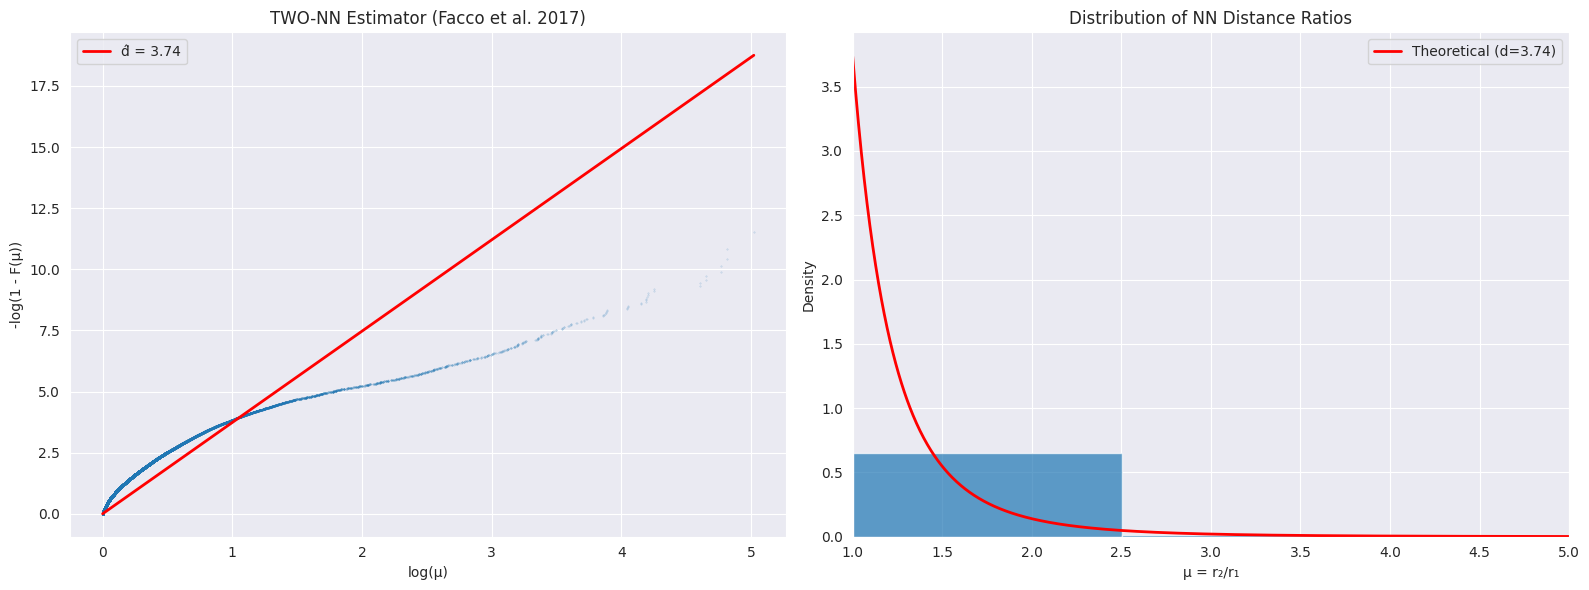

In [10]:
# TWO-NN intrinsic dimensionality estimator (Facco et al. 2017)
# Uses sample_embeddings from cell 8

# Cast to float64 for distance precision (100K × 384 = ~300 MB)
sample_f64 = sample_embeddings.astype(np.float64)
sq_norms_f64 = np.einsum('ij,ij->i', sample_f64, sample_f64)

# Find two nearest neighbors per point in chunks (~4 GB per chunk in float64)
n_sample = len(sample_f64)
nn1 = np.full(n_sample, np.inf)
nn2 = np.full(n_sample, np.inf)
chunk_size = 5_000
for start in range(0, n_sample, chunk_size):
    end = min(start + chunk_size, n_sample)
    sq_dists = sq_norms_f64[start:end, None] + sq_norms_f64[None, :] - 2 * (sample_f64[start:end] @ sample_f64.T)
    np.maximum(sq_dists, 0, out = sq_dists)
    # Set self-distances to inf
    for i in range(end - start):
        sq_dists[i, start + i] = np.inf
    # Two smallest squared distances per row
    top2_sq = np.partition(sq_dists, 1, axis = 1)[:, :2]
    top2_sq.sort(axis = 1)
    nn1[start:end] = np.sqrt(top2_sq[:, 0])
    nn2[start:end] = np.sqrt(top2_sq[:, 1])
    del sq_dists, top2_sq

del sample_f64, sq_norms_f64

# Compute μ = r₂/r₁
mu = nn2 / nn1
valid = np.isfinite(mu) & (mu > 1)
mu = np.sort(mu[valid])

# Empirical CDF
n = len(mu)
F_emp = np.arange(1, n + 1) / n

# Fit: from F(μ) = 1 - μ^(-d), we get -log(1 - F) = d * log(μ)
# Slope through origin = d̂
x = np.log(mu[:-1])  # exclude last point where F_emp = 1
y = -np.log(1 - F_emp[:-1])
d_hat = np.sum(x * y) / np.sum(x * x)

print(f'TWO-NN intrinsic dimensionality estimate: d̂ = {d_hat:.2f}')
print(f'Valid μ values: {n:,} / {n_sample:,}')
print(f'μ range: {mu.min():.6f} - {mu.max():.6f}, mean: {mu.mean():.6f}')

# Plot
fig, axes = plt.subplots(1, 2, figsize = (16, 6))

# Left: log(μ) vs -log(1-F) with fitted line
axes[0].scatter(x, y, s = 0.1, alpha = 0.3)
x_fit = np.linspace(0, x.max(), 100)
axes[0].plot(x_fit, d_hat * x_fit, 'r-', linewidth = 2, label = f'd̂ = {d_hat:.2f}')
axes[0].set_xlabel('log(μ)')
axes[0].set_ylabel('-log(1 - F(μ))')
axes[0].set_title('TWO-NN Estimator (Facco et al. 2017)')
axes[0].legend()

# Right: histogram of μ with theoretical PDF f(μ) = d * μ^(-(d+1))
axes[1].hist(mu, bins = 100, alpha = 0.7, density = True)
mu_theory = np.linspace(1, min(5, mu.max()), 1000)
pdf_theory = d_hat * mu_theory ** (-(d_hat + 1))
axes[1].plot(mu_theory, pdf_theory, 'r-', linewidth = 2, label = f'Theoretical (d={d_hat:.2f})')
axes[1].set_xlabel('μ = r₂/r₁')
axes[1].set_ylabel('Density')
axes[1].set_title('Distribution of NN Distance Ratios')
axes[1].legend()
axes[1].set_xlim(1, min(5, mu.max()))

plt.tight_layout()
plt.show()

In [13]:
# t-SNE visualization using openTSNE (full dataset)
from openTSNE import TSNE

# Use all embeddings
tsne_sample_size = len(embeddings)
tsne_idx = np.arange(tsne_sample_size)
tsne_embeddings = embeddings
tsne_ids = embedding_ids
tsne_lengths = lengths

print(f'Using all {tsne_sample_size:,} embeddings for t-SNE')
print(f'Running t-SNE (this may take a while)...')

# Run t-SNE with Euclidean metric (better for this VAE than cosine)
tsne = TSNE(
    n_components = 2,
    perplexity = 30,
    metric = 'euclidean',
    n_jobs = -1,  # Use all cores
    random_state = 42,
    verbose = True
)
tsne_result = tsne.fit(tsne_embeddings)

print(f't-SNE complete. Result shape: {tsne_result.shape}')

Using all 154,040 embeddings for t-SNE
Running t-SNE (this may take a while)...
--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, n_jobs=-1, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 12.28 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 2.12 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.27 seconds
===> Running optimization with exaggeration=12.00, lr=12836.67 for 250 iterations...
Iteration   50, KL divergence 6.0464, 50 iterations in 2.1279 sec
Iteration  100, KL divergence 5.4100, 50 iterations in 2.1023 sec
Iteration  150, KL divergence 5.0745, 50 iterations in 2.0534 sec
Iteration  200, KL divergence 4.8609, 50 iterations in 2.1018 sec
Iteration  250, KL divergence 4.7093, 50 iterations in 2.1276 

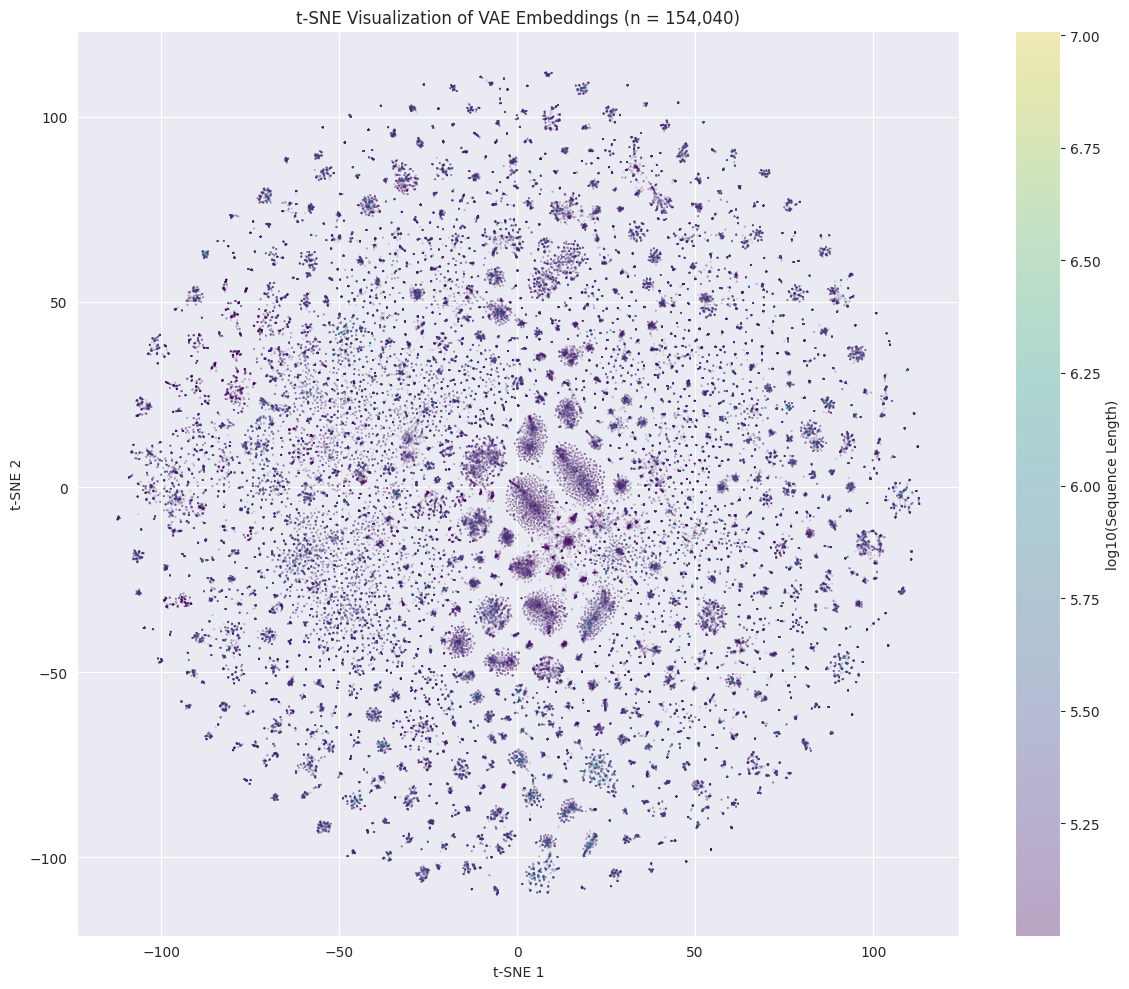

In [14]:
# Plot t-SNE result
fig, ax = plt.subplots(figsize = (12, 10))

# Use scatter with small alpha for 1M points
scatter = ax.scatter(
    tsne_result[:, 0],
    tsne_result[:, 1],
    c = np.log10(tsne_lengths),  # Color by log sequence length
    cmap = 'viridis',
    s = 0.1,
    alpha = 0.3
)
cbar = plt.colorbar(scatter, ax = ax)
cbar.set_label('log10(Sequence Length)')

ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_title(f't-SNE Visualization of VAE Embeddings (n = {tsne_sample_size:,})')
plt.tight_layout()
plt.show()

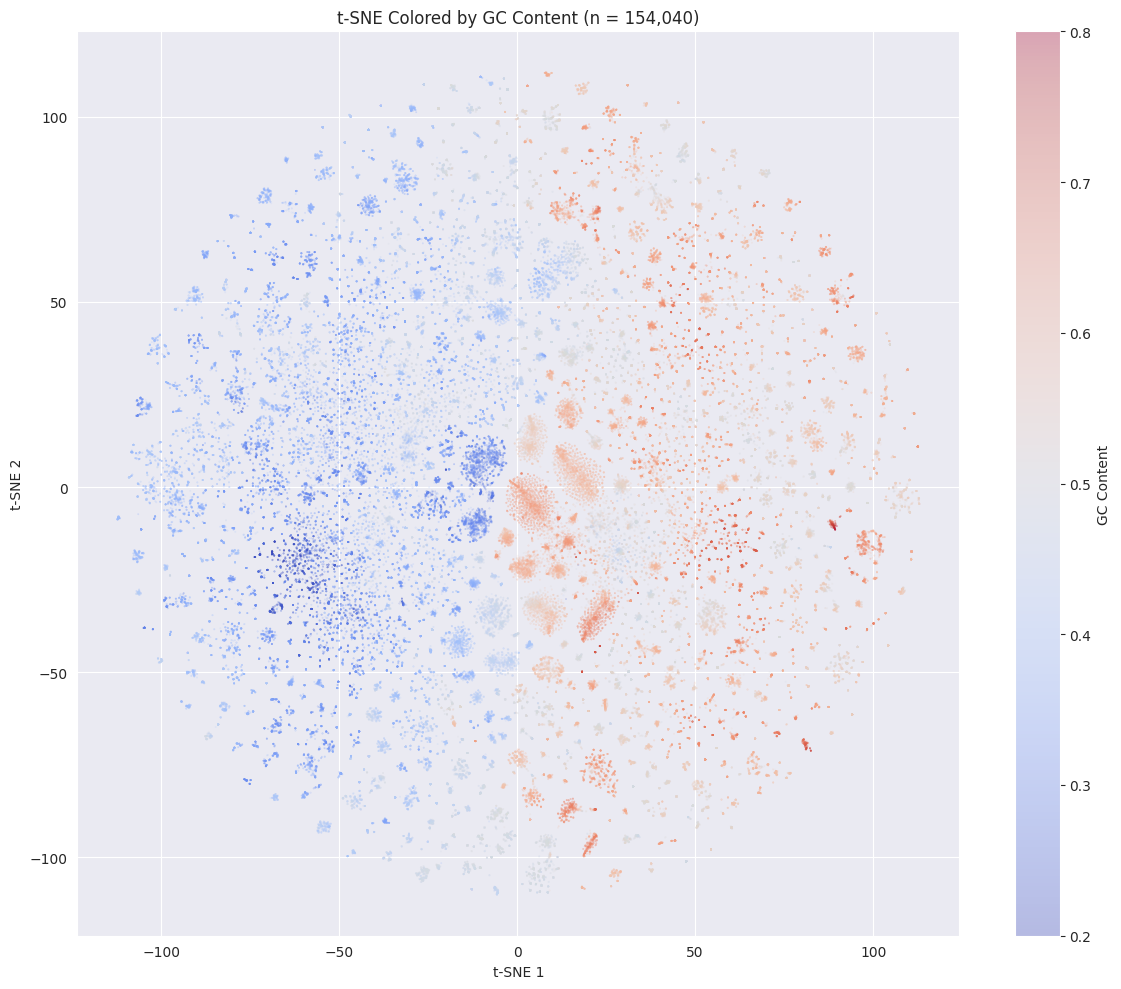

GC content range: 0.141 - 0.829
GC content mean: 0.477


In [15]:
# Plot t-SNE colored by GC content (last column of kmers)
gc_content = kmers[tsne_idx, -1]

fig, ax = plt.subplots(figsize = (12, 10))
scatter = ax.scatter(
    tsne_result[:, 0],
    tsne_result[:, 1],
    c = gc_content,
    cmap = 'coolwarm',
    s = 0.1,
    alpha = 0.3,
    vmin = 0.2,
    vmax = 0.8
)
cbar = plt.colorbar(scatter, ax = ax)
cbar.set_label('GC Content')

ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_title(f't-SNE Colored by GC Content (n = {tsne_sample_size:,})')
plt.tight_layout()
plt.show()

print(f'GC content range: {gc_content.min():.3f} - {gc_content.max():.3f}')
print(f'GC content mean: {gc_content.mean():.3f}')

SFE sequences: 81,295 (52.8%)
SE sequences: 72,745 (47.2%)


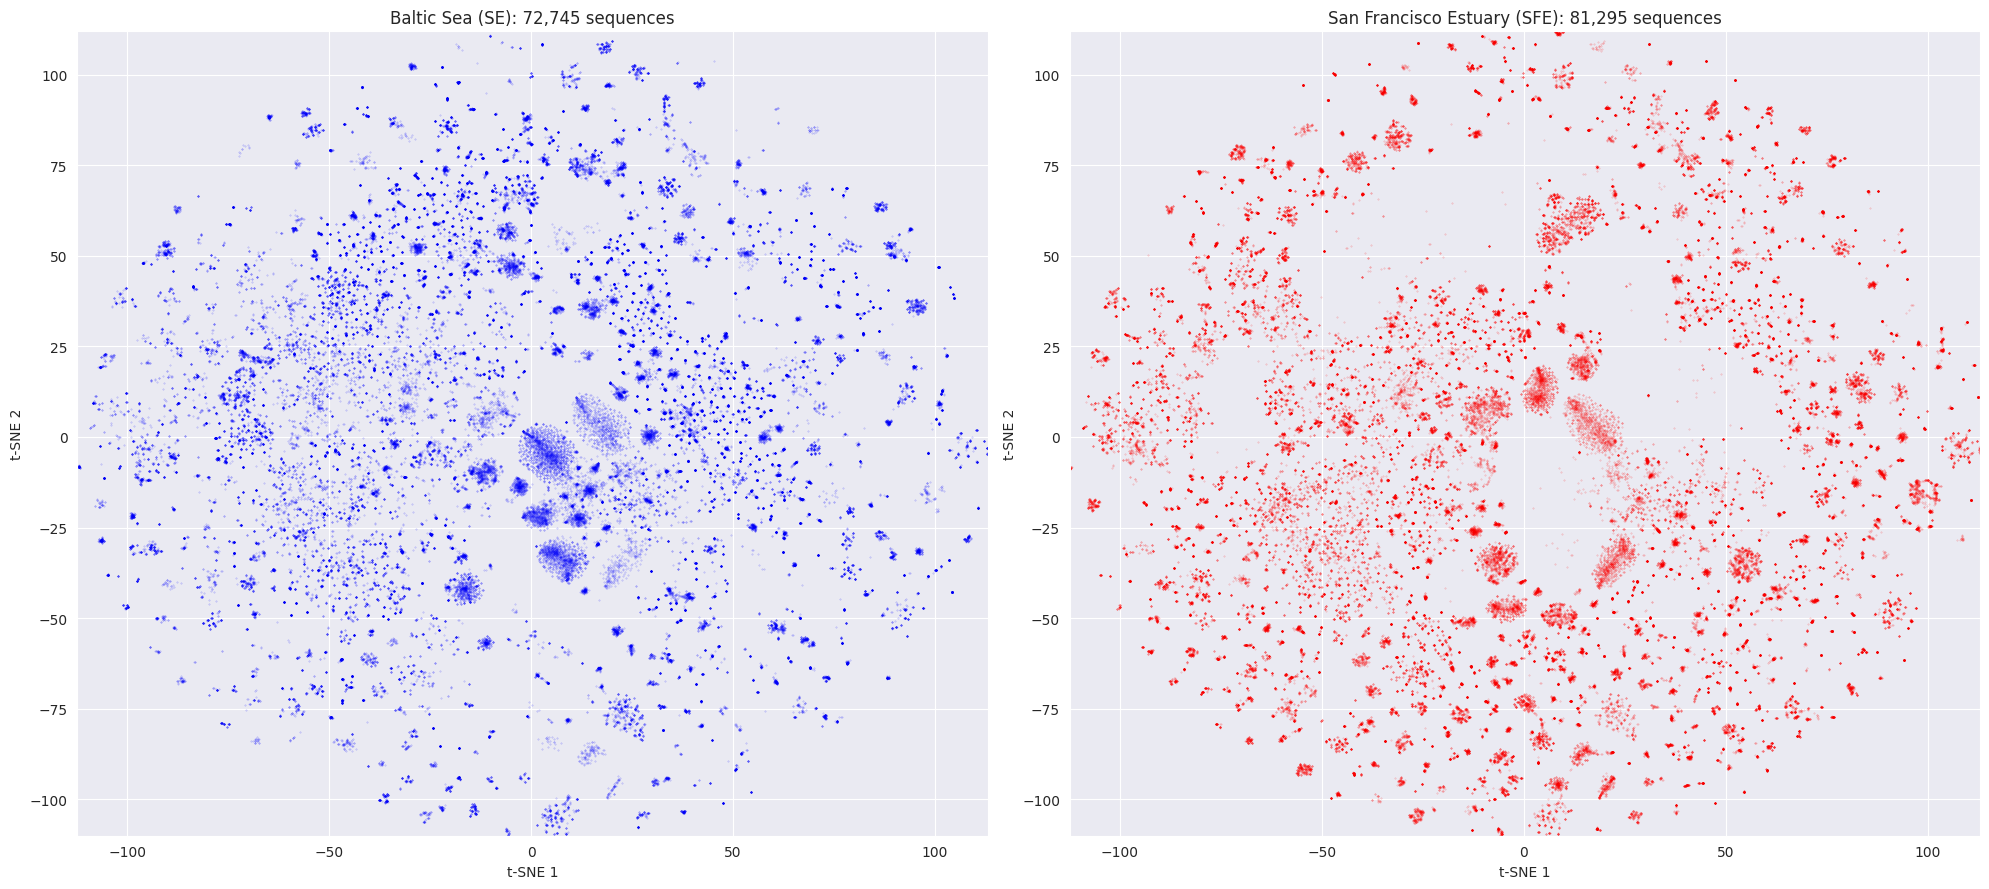

In [16]:
# Plot t-SNE colored by ID prefix (SFE vs SE) - side by side
is_sfe = np.array([id.startswith('SFE') for id in tsne_ids])
is_se = np.array([id.startswith('SE') for id in tsne_ids])

print(f'SFE sequences: {is_sfe.sum():,} ({100 * is_sfe.mean():.1f}%)')
print(f'SE sequences: {is_se.sum():,} ({100 * is_se.mean():.1f}%)')

fig, axes = plt.subplots(1, 2, figsize = (20, 9))

# Left: SE only (Baltic)
axes[0].scatter(
    tsne_result[is_se, 0],
    tsne_result[is_se, 1],
    c = 'blue',
    s = 0.1,
    alpha = 0.3
)
axes[0].set_xlabel('t-SNE 1')
axes[0].set_ylabel('t-SNE 2')
axes[0].set_title(f'Baltic Sea (SE): {is_se.sum():,} sequences')

# Right: SFE only (San Francisco Estuary)
axes[1].scatter(
    tsne_result[is_sfe, 0],
    tsne_result[is_sfe, 1],
    c = 'red',
    s = 0.1,
    alpha = 0.3
)
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')
axes[1].set_title(f'San Francisco Estuary (SFE): {is_sfe.sum():,} sequences')

# Match axis limits so they're comparable
xlim = (tsne_result[:, 0].min(), tsne_result[:, 0].max())
ylim = (tsne_result[:, 1].min(), tsne_result[:, 1].max())
for ax in axes:
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

plt.tight_layout()
plt.show()

Running HDBSCAN on 154,040 points...


/home/torben/Embedding/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/torben/Embedding/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Clusters found: 462
Noise points: 33,681 (21.9%)


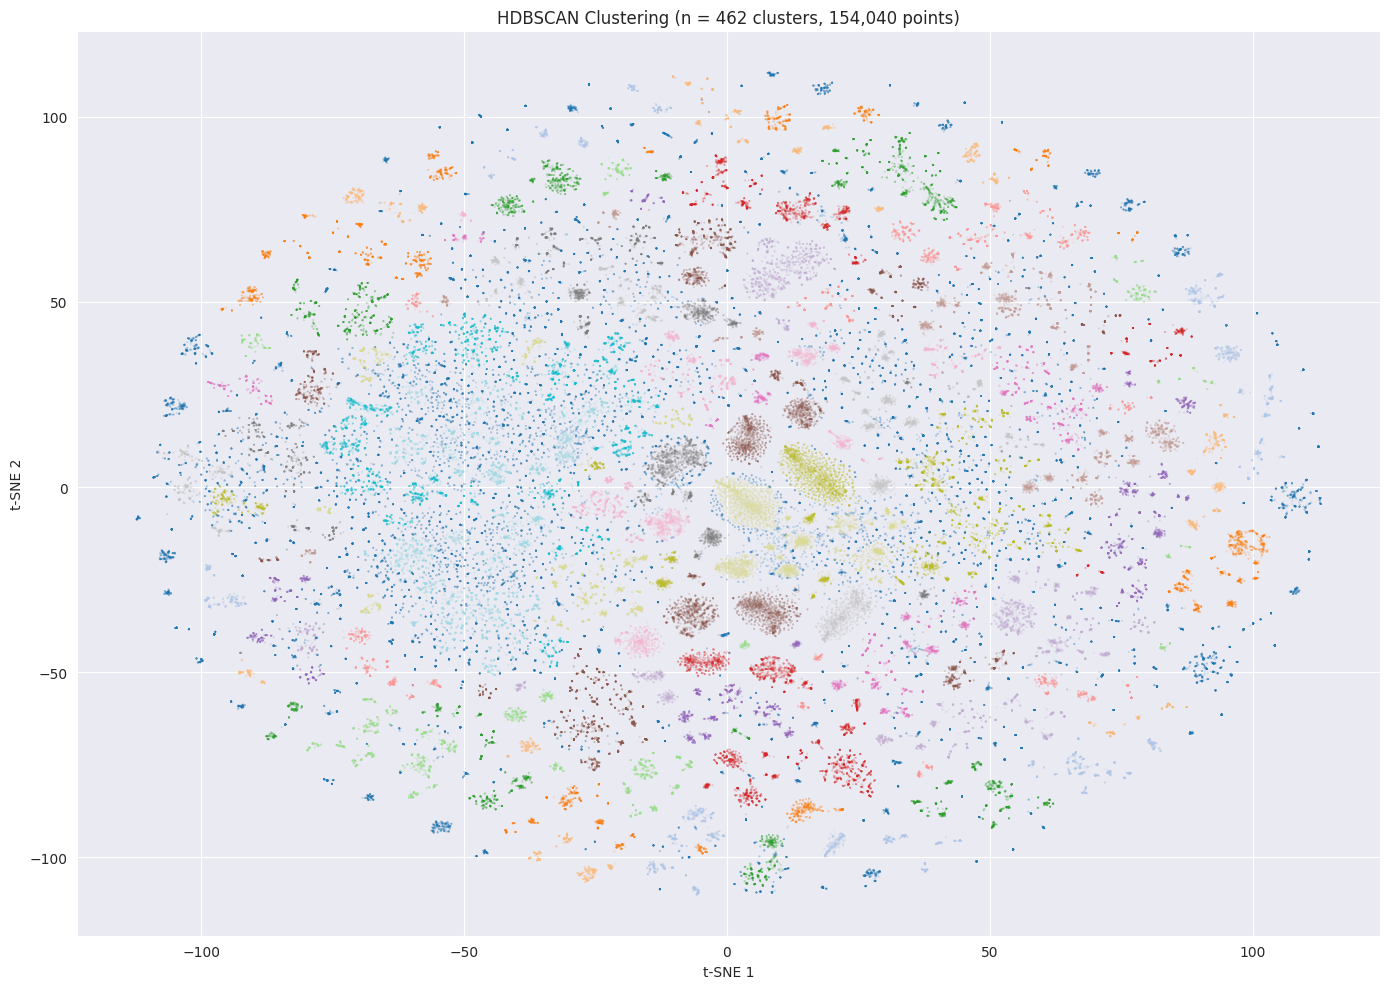

In [17]:
# HDBSCAN clustering on full t-SNE coordinates
from hdbscan import HDBSCAN

print(f'Running HDBSCAN on {len(tsne_result):,} points...')
clusterer = HDBSCAN(min_cluster_size = 100, min_samples = 50)
labels = clusterer.fit_predict(tsne_result)

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = (labels == -1).sum()

print(f'Clusters found: {n_clusters}')
print(f'Noise points: {n_noise:,} ({100 * n_noise / len(labels):.1f}%)')

# Plot with cluster colors
fig, ax = plt.subplots(figsize = (14, 10))
scatter = ax.scatter(
    tsne_result[:, 0],
    tsne_result[:, 1],
    c = labels,
    cmap = 'tab20',
    s = 0.1,
    alpha = 0.3
)
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_title(f'HDBSCAN Clustering (n = {n_clusters} clusters, {len(tsne_result):,} points)')
plt.tight_layout()
plt.show()

In [13]:
# List clusters and save to files
unique_labels = sorted(set(labels) - {-1})  # Exclude noise

# Save cluster sizes to clusters.tsv
with open('clusters.tsv', 'w') as f:
    f.write('cluster\tsize\n')
    for label in unique_labels:
        size = (labels == label).sum()
        f.write(f'{label}\t{size}\n')
    f.write(f'noise\t{(labels == -1).sum()}\n')

print(f'Saved cluster sizes to clusters.tsv')

# Save cluster memberships to cluster_members.tsv
with open('cluster_members.tsv', 'w') as f:
    f.write('cluster\tsequence_ids\n')
    for label in unique_labels:
        mask = labels == label
        ids = embedding_ids[mask]
        f.write(f'{label}\t{",".join(ids)}\n')

print(f'Saved cluster memberships to cluster_members.tsv')

Saved cluster sizes to clusters.tsv
Saved cluster memberships to cluster_members.tsv


In [19]:
# Phase 1: Distance landscape from kNN graph
# Parse nn1, nn2, and nn50 distances from neighbors TSV

tsv_path = 'Runs/neighbors_100_NCBI_5.tsv'
n_sequences = len(embeddings)

nn1_dists = np.empty(n_sequences, dtype = np.float32)
nn2_dists = np.empty(n_sequences, dtype = np.float32)
nn50_dists = np.empty(n_sequences, dtype = np.float32)

with open(tsv_path, 'r') as f:
    for i, line in enumerate(f):
        fields = line.rstrip('\n').split('\t')
        nn1_dists[i] = float(fields[1].split('(')[1].rstrip(')'))
        nn2_dists[i] = float(fields[2].split('(')[1].rstrip(')'))
        nn50_dists[i] = float(fields[-1].split('(')[1].rstrip(')'))
        if (i + 1) % 1_000_000 == 0:
            print(f'Parsed {i + 1:,} / {n_sequences:,} lines...')

print(f'\nParsed all {n_sequences:,} lines')
print(f'nn1  range: {nn1_dists.min():.4f} - {nn1_dists.max():.4f}, mean: {nn1_dists.mean():.4f}, median: {np.median(nn1_dists):.4f}')
print(f'nn2  range: {nn2_dists.min():.4f} - {nn2_dists.max():.4f}, mean: {nn2_dists.mean():.4f}, median: {np.median(nn2_dists):.4f}')
print(f'nn50 range: {nn50_dists.min():.4f} - {nn50_dists.max():.4f}, mean: {nn50_dists.mean():.4f}, median: {np.median(nn50_dists):.4f}')

# Percentiles
for p in [1, 5, 10, 25, 50, 75, 90, 95, 99]:
    print(f'nn1 P{p:2d}: {np.percentile(nn1_dists, p):.4f}    nn50 P{p:2d}: {np.percentile(nn50_dists, p):.4f}')


Parsed all 154,040 lines
nn1  range: 0.0095 - 27.3159, mean: 3.2342, median: 2.9605
nn2  range: 0.0105 - 27.3223, mean: 3.7210, median: 3.4365
nn50 range: 1.5139 - 27.7886, mean: 6.3009, median: 5.7512
nn1 P 1: 0.3059    nn50 P 1: 2.8245
nn1 P 5: 0.8178    nn50 P 5: 3.4547
nn1 P10: 1.1951    nn50 P10: 3.8149
nn1 P25: 1.9638    nn50 P25: 4.5229
nn1 P50: 2.9605    nn50 P50: 5.7512
nn1 P75: 4.0766    nn50 P75: 7.6762
nn1 P90: 5.4555    nn50 P90: 9.5427
nn1 P95: 6.6941    nn50 P95: 10.7376
nn1 P99: 9.7976    nn50 P99: 13.3212


In [20]:
# Phase 1: Distance landscape from kNN graph
# Parse nn1, nn2, and nn50 distances from neighbors TSV

tsv_path = 'Runs/neighbors_100_NCBI_5.tsv'
n_sequences = len(embeddings)

nn1_dists = np.empty(n_sequences, dtype = np.float32)
nn2_dists = np.empty(n_sequences, dtype = np.float32)
nn50_dists = np.empty(n_sequences, dtype = np.float32)

with open(tsv_path, 'r') as f:
    for i, line in enumerate(f):
        fields = line.rstrip('\n').split('\t')
        nn1_dists[i] = float(fields[1].split('(')[1].rstrip(')'))
        nn2_dists[i] = float(fields[2].split('(')[1].rstrip(')'))
        nn50_dists[i] = float(fields[-1].split('(')[1].rstrip(')'))
        if (i + 1) % 1_000_000 == 0:
            print(f'Parsed {i + 1:,} / {n_sequences:,} lines...')

print(f'\nParsed all {n_sequences:,} lines')
print(f'nn1  range: {nn1_dists.min():.4f} - {nn1_dists.max():.4f}, mean: {nn1_dists.mean():.4f}, median: {np.median(nn1_dists):.4f}')
print(f'nn2  range: {nn2_dists.min():.4f} - {nn2_dists.max():.4f}, mean: {nn2_dists.mean():.4f}, median: {np.median(nn2_dists):.4f}')
print(f'nn50 range: {nn50_dists.min():.4f} - {nn50_dists.max():.4f}, mean: {nn50_dists.mean():.4f}, median: {np.median(nn50_dists):.4f}')

# Percentiles
for p in [1, 5, 10, 25, 50, 75, 90, 95, 99]:
    print(f'nn1 P{p:2d}: {np.percentile(nn1_dists, p):.4f}    nn50 P{p:2d}: {np.percentile(nn50_dists, p):.4f}')


Parsed all 154,040 lines
nn1  range: 0.0095 - 27.3159, mean: 3.2342, median: 2.9605
nn2  range: 0.0105 - 27.3223, mean: 3.7210, median: 3.4365
nn50 range: 1.5139 - 27.7886, mean: 6.3009, median: 5.7512
nn1 P 1: 0.3059    nn50 P 1: 2.8245
nn1 P 5: 0.8178    nn50 P 5: 3.4547
nn1 P10: 1.1951    nn50 P10: 3.8149
nn1 P25: 1.9638    nn50 P25: 4.5229
nn1 P50: 2.9605    nn50 P50: 5.7512
nn1 P75: 4.0766    nn50 P75: 7.6762
nn1 P90: 5.4555    nn50 P90: 9.5427
nn1 P95: 6.6941    nn50 P95: 10.7376
nn1 P99: 9.7976    nn50 P99: 13.3212


In [25]:
# Distance-threshold clustering: connect sequences within d < 5
# Edges weighted by 1/(distance + epsilon) so Leiden prefers cutting distant edges
import igraph as ig
import leidenalg

d_threshold = 5.0
epsilon = 0.1
tsv_path = 'Runs/neighbors_100_NCBI_5.tsv'
n_sequences = len(embeddings)

# Build ID -> index mapping
id_to_idx = {id_: i for i, id_ in enumerate(embedding_ids)}

# Parse neighbors TSV, collect edges with distance < threshold
print(f'Building edge list with d < {d_threshold}, weights = 1/(d + {epsilon})...')
edges = []
weights = []

with open(tsv_path, 'r') as f:
    for i, line in enumerate(f):
        fields = line.rstrip('\n').split('\t')
        for field in fields[1:]:
            paren = field.rfind('(')
            dist = float(field[paren + 1:-1])
            if dist >= d_threshold:
                break  # distance-sorted
            j = id_to_idx[field[:paren]]
            edges.append((i, j))
            weights.append(1.0 / (dist + epsilon))
        if (i + 1) % 1_000_000 == 0:
            print(f'  Parsed {i + 1:,} / {n_sequences:,}... ({len(edges):,} edges so far)')

print(f'\nTotal directed edges: {len(edges):,}')

# Build igraph graph
print('Building igraph graph...')
g = ig.Graph(n = n_sequences, edges = edges, directed = True)
g.es['weight'] = weights
del edges, weights

# When collapsing to undirected, combine weights by max (keep strongest connection)
g = g.as_undirected(mode = 'collapse', combine_edges = {'weight': 'max'})
print(f'Graph: {g.vcount():,} vertices, {g.ecount():,} edges')
w = np.array(g.es['weight'])
print(f'Weight range: {w.min():.4f} - {w.max():.4f}, mean: {w.mean():.4f}')

# Run Leiden with weights
print(f'Running Leiden (resolution=1.0, weighted)...')
partition = leidenalg.find_partition(g, leidenalg.RBConfigurationVertexPartition,
                                     weights = 'weight', n_iterations = -1)
del g

component_labels = np.array(partition.membership)
component_sizes = np.bincount(component_labels)
n_components = len(component_sizes)
n_singletons = (component_sizes == 1).sum()
nonsingleton_sizes = np.sort(component_sizes[component_sizes > 1])[::-1]
n_clustered = component_sizes[component_sizes > 1].sum()

print(f'\n{"=" * 60}')
print(f'Leiden on distance-threshold graph (d < {d_threshold}, weighted)')
print(f'{"=" * 60}')
print(f'Quality (modularity): {partition.quality():.4f}')
print(f'Total communities: {n_components:,}')
print(f'Singletons: {n_singletons:,} ({100 * n_singletons / n_sequences:.1f}%)')
print(f'Non-singleton communities: {len(nonsingleton_sizes):,}')
print(f'Clustered sequences: {n_clustered:,} ({100 * n_clustered / n_sequences:.1f}%)')
if len(nonsingleton_sizes) > 0:
    print(f'  Size range: {nonsingleton_sizes[-1]:,} - {nonsingleton_sizes[0]:,}')
    print(f'  Mean size: {nonsingleton_sizes.mean():.1f}')
    print(f'  Median size: {np.median(nonsingleton_sizes):.0f}')

print(f'\nTop 20 communities:')
for rank, size in enumerate(nonsingleton_sizes[:20]):
    print(f'  {rank + 1:3d}. {size:,} sequences')

Building edge list with d < 5.0, weights = 1/(d + 0.1)...

Total directed edges: 3,987,831
Building igraph graph...
Graph: 154,040 vertices, 2,723,248 edges
Weight range: 0.1961 - 9.1324, mean: 0.2700
Running Leiden (resolution=1.0, weighted)...

Leiden on distance-threshold graph (d < 5.0, weighted)
Quality (modularity): 1461214.0845
Total communities: 25,950
Singletons: 20,161 (13.1%)
Non-singleton communities: 5,789
Clustered sequences: 133,879 (86.9%)
  Size range: 2 - 1,695
  Mean size: 23.1
  Median size: 4

Top 20 communities:
    1. 1,695 sequences
    2. 1,611 sequences
    3. 1,558 sequences
    4. 1,050 sequences
    5. 1,013 sequences
    6. 1,011 sequences
    7. 994 sequences
    8. 972 sequences
    9. 936 sequences
   10. 919 sequences
   11. 903 sequences
   12. 881 sequences
   13. 816 sequences
   14. 815 sequences
   15. 795 sequences
   16. 794 sequences
   17. 792 sequences
   18. 784 sequences
   19. 773 sequences
   20. 772 sequences


In [26]:
# Mutual kNN Leiden: keep only edges where both directions exist
# Edges weighted by 1/(distance + epsilon)
import igraph as ig
import leidenalg

d_threshold = 5.0
epsilon = 0.1
tsv_path = 'Runs/neighbors_100_NCBI_5.tsv'
n_sequences = len(embeddings)

id_to_idx = {id_: i for i, id_ in enumerate(embedding_ids)}

# Pass 1: collect all directed edges with distance < threshold
print(f'Building directed edge set with d < {d_threshold}...')
directed_edges = {}  # (i, j) -> distance

with open(tsv_path, 'r') as f:
    for i, line in enumerate(f):
        fields = line.rstrip('\n').split('\t')
        for field in fields[1:]:
            paren = field.rfind('(')
            dist = float(field[paren + 1:-1])
            if dist >= d_threshold:
                break
            j = id_to_idx[field[:paren]]
            directed_edges[(i, j)] = dist
        if (i + 1) % 1_000_000 == 0:
            print(f'  Parsed {i + 1:,} / {n_sequences:,}... ({len(directed_edges):,} directed edges)')

print(f'Total directed edges: {len(directed_edges):,}')

# Pass 2: keep only mutual edges (both directions exist)
print('Filtering to mutual edges...')
mutual_edges = []
mutual_weights = []

seen = set()
for (i, j), dist_ij in directed_edges.items():
    if i < j and (j, i) in directed_edges:
        # Use the smaller distance (closer direction) for weight
        dist = min(dist_ij, directed_edges[(j, i)])
        mutual_edges.append((i, j))
        mutual_weights.append(1.0 / (dist + epsilon))

del directed_edges

# Count connected vs isolated nodes
connected = set()
for i, j in mutual_edges:
    connected.add(i)
    connected.add(j)
n_connected = len(connected)
del connected

print(f'Mutual edges: {len(mutual_edges):,}')
print(f'Connected nodes: {n_connected:,} ({100 * n_connected / n_sequences:.1f}%)')
print(f'Isolated nodes: {n_sequences - n_connected:,} ({100 * (1 - n_connected / n_sequences):.1f}%)')

# Build igraph graph
print('Building igraph graph...')
g = ig.Graph(n = n_sequences, edges = mutual_edges, directed = False)
g.es['weight'] = mutual_weights
del mutual_edges, mutual_weights

w = np.array(g.es['weight'])
print(f'Graph: {g.vcount():,} vertices, {g.ecount():,} edges')
print(f'Weight range: {w.min():.4f} - {w.max():.4f}, mean: {w.mean():.4f}')

# Run Leiden with weights
print(f'Running Leiden (resolution=1.0, weighted, mutual kNN)...')
partition = leidenalg.find_partition(g, leidenalg.RBConfigurationVertexPartition,
                                     weights = 'weight', n_iterations = -1)
del g

mutual_labels = np.array(partition.membership)
mutual_sizes = np.bincount(mutual_labels)
n_components = len(mutual_sizes)
n_singletons = (mutual_sizes == 1).sum()
nonsingleton_sizes = np.sort(mutual_sizes[mutual_sizes > 1])[::-1]
n_clustered = mutual_sizes[mutual_sizes > 1].sum()

print(f'\n{"=" * 60}')
print(f'Leiden on mutual kNN graph (d < {d_threshold}, weighted)')
print(f'{"=" * 60}')
print(f'Quality (modularity): {partition.quality():.4f}')
print(f'Total communities: {n_components:,}')
print(f'Singletons: {n_singletons:,} ({100 * n_singletons / n_sequences:.1f}%)')
print(f'Non-singleton communities: {len(nonsingleton_sizes):,}')
print(f'Clustered sequences: {n_clustered:,} ({100 * n_clustered / n_sequences:.1f}%)')
if len(nonsingleton_sizes) > 0:
    print(f'  Size range: {nonsingleton_sizes[-1]:,} - {nonsingleton_sizes[0]:,}')
    print(f'  Mean size: {nonsingleton_sizes.mean():.1f}')
    print(f'  Median size: {np.median(nonsingleton_sizes):.0f}')

print(f'\nTop 20 communities:')
for rank, size in enumerate(nonsingleton_sizes[:20]):
    print(f'  {rank + 1:3d}. {size:,} sequences')

Building directed edge set with d < 5.0...
Total directed edges: 3,987,831
Filtering to mutual edges...
Mutual edges: 1,264,583
Connected nodes: 130,705 (84.9%)
Isolated nodes: 23,335 (15.1%)
Building igraph graph...
Graph: 154,040 vertices, 1,264,583 edges
Weight range: 0.1961 - 9.1324, mean: 0.3018
Running Leiden (resolution=1.0, weighted, mutual kNN)...

Leiden on mutual kNN graph (d < 5.0, weighted)
Quality (modularity): 761496.4390
Total communities: 29,587
Singletons: 23,335 (15.1%)
Non-singleton communities: 6,252
Clustered sequences: 130,705 (84.9%)
  Size range: 2 - 1,596
  Mean size: 20.9
  Median size: 4

Top 20 communities:
    1. 1,596 sequences
    2. 1,584 sequences
    3. 1,224 sequences
    4. 890 sequences
    5. 871 sequences
    6. 844 sequences
    7. 809 sequences
    8. 776 sequences
    9. 759 sequences
   10. 747 sequences
   11. 716 sequences
   12. 689 sequences
   13. 687 sequences
   14. 665 sequences
   15. 662 sequences
   16. 600 sequences
   17. 550 seq

In [27]:
# In-degree capped Leiden: limit how many sequences can point to any single node
# Edges weighted by 1/(distance + epsilon)
import igraph as ig
import leidenalg

d_threshold = 5.0
epsilon = 0.1
max_in_degree = 100
tsv_path = 'Runs/neighbors_100_NCBI_5.tsv'
n_sequences = len(embeddings)

id_to_idx = {id_: i for i, id_ in enumerate(embedding_ids)}

# Pass 1: collect all directed edges with distance < threshold
print(f'Building directed edge list with d < {d_threshold}...')
directed_edges = []  # (i, j, dist)

with open(tsv_path, 'r') as f:
    for i, line in enumerate(f):
        fields = line.rstrip('\n').split('\t')
        for field in fields[1:]:
            paren = field.rfind('(')
            dist = float(field[paren + 1:-1])
            if dist >= d_threshold:
                break
            j = id_to_idx[field[:paren]]
            directed_edges.append((i, j, dist))
        if (i + 1) % 1_000_000 == 0:
            print(f'  Parsed {i + 1:,} / {n_sequences:,}... ({len(directed_edges):,} edges)')

print(f'Total directed edges: {len(directed_edges):,}')

# Pass 2: cap in-degree — for each target node, keep only the closest max_in_degree incoming edges
print(f'Capping in-degree to {max_in_degree}...')
from collections import defaultdict

# Group by target node
incoming = defaultdict(list)
for i, j, dist in directed_edges:
    incoming[j].append((dist, i))

# For each target, keep only closest max_in_degree sources
capped_edges = []
capped_weights = []
n_dropped = 0

for j, sources in incoming.items():
    if len(sources) > max_in_degree:
        sources.sort()  # sort by distance (closest first)
        n_dropped += len(sources) - max_in_degree
        sources = sources[:max_in_degree]
    for dist, i in sources:
        capped_edges.append((i, j))
        capped_weights.append(1.0 / (dist + epsilon))

del directed_edges, incoming

print(f'Edges after capping: {len(capped_edges):,} (dropped {n_dropped:,})')

# Build igraph graph
print('Building igraph graph...')
g = ig.Graph(n = n_sequences, edges = capped_edges, directed = True)
g.es['weight'] = capped_weights
del capped_edges, capped_weights

g = g.as_undirected(mode = 'collapse', combine_edges = {'weight': 'max'})
print(f'Graph: {g.vcount():,} vertices, {g.ecount():,} edges')
w = np.array(g.es['weight'])
print(f'Weight range: {w.min():.4f} - {w.max():.4f}, mean: {w.mean():.4f}')

# Run Leiden with weights
print(f'Running Leiden (resolution=1.0, weighted, in-degree capped at {max_in_degree})...')
partition = leidenalg.find_partition(g, leidenalg.RBConfigurationVertexPartition,
                                     weights = 'weight', n_iterations = -1)
del g

capped_labels = np.array(partition.membership)
capped_sizes = np.bincount(capped_labels)
n_components = len(capped_sizes)
n_singletons = (capped_sizes == 1).sum()
nonsingleton_sizes = np.sort(capped_sizes[capped_sizes > 1])[::-1]
n_clustered = capped_sizes[capped_sizes > 1].sum()

print(f'\n{"=" * 60}')
print(f'Leiden on in-degree capped graph (d < {d_threshold}, cap = {max_in_degree})')
print(f'{"=" * 60}')
print(f'Quality (modularity): {partition.quality():.4f}')
print(f'Total communities: {n_components:,}')
print(f'Singletons: {n_singletons:,} ({100 * n_singletons / n_sequences:.1f}%)')
print(f'Non-singleton communities: {len(nonsingleton_sizes):,}')
print(f'Clustered sequences: {n_clustered:,} ({100 * n_clustered / n_sequences:.1f}%)')
if len(nonsingleton_sizes) > 0:
    print(f'  Size range: {nonsingleton_sizes[-1]:,} - {nonsingleton_sizes[0]:,}')
    print(f'  Mean size: {nonsingleton_sizes.mean():.1f}')
    print(f'  Median size: {np.median(nonsingleton_sizes):.0f}')

print(f'\nTop 20 communities:')
for rank, size in enumerate(nonsingleton_sizes[:20]):
    print(f'  {rank + 1:3d}. {size:,} sequences')

Building directed edge list with d < 5.0...
Total directed edges: 3,987,831
Capping in-degree to 100...
Edges after capping: 3,550,516 (dropped 437,315)
Building igraph graph...
Graph: 154,040 vertices, 2,285,933 edges
Weight range: 0.1961 - 9.1324, mean: 0.2760
Running Leiden (resolution=1.0, weighted, in-degree capped at 100)...

Leiden on in-degree capped graph (d < 5.0, cap = 100)
Quality (modularity): 1255665.7295
Total communities: 26,146
Singletons: 20,316 (13.2%)
Non-singleton communities: 5,830
Clustered sequences: 133,724 (86.8%)
  Size range: 2 - 1,695
  Mean size: 22.9
  Median size: 4

Top 20 communities:
    1. 1,695 sequences
    2. 1,609 sequences
    3. 1,533 sequences
    4. 1,012 sequences
    5. 987 sequences
    6. 978 sequences
    7. 972 sequences
    8. 936 sequences
    9. 919 sequences
   10. 907 sequences
   11. 889 sequences
   12. 881 sequences
   13. 815 sequences
   14. 796 sequences
   15. 792 sequences
   16. 784 sequences
   17. 771 sequences
   18. 72

In [24]:
# GC validation for all three Leiden methods (top 3 communities each)
rng_val = np.random.default_rng(42)

methods = [
    ('Symmetric d<5', component_labels, component_sizes),
    ('Mutual d<5', mutual_labels, mutual_sizes),
    ('Capped d<5', capped_labels, capped_sizes),
]

for method_name, labels, sizes in methods:
    print(f'{"=" * 70}')
    print(f'{method_name}')
    print(f'{"=" * 70}')

    sorted_labels = np.argsort(-sizes)

    for rank in range(3):
        label = sorted_labels[rank]
        comm_idx = np.where(labels == label)[0]
        size = sizes[label]
        n_sample = min(1000, size)

        if n_sample < size:
            sample_idx = rng_val.choice(comm_idx, size = n_sample, replace = False)
        else:
            sample_idx = comm_idx

        sample_emb = embeddings[sample_idx]
        sq_norms = np.einsum('ij,ij->i', sample_emb, sample_emb)
        sq_dists = sq_norms[:, None] + sq_norms[None, :] - 2 * (sample_emb @ sample_emb.T)
        np.maximum(sq_dists, 0, out = sq_dists)
        np.fill_diagonal(sq_dists, 0)
        d = np.sqrt(sq_dists[np.triu_indices(n_sample, k = 1)])

        gc = one_mers[comm_idx, 1]
        comm_lengths = lengths[comm_idx]

        gc_span = 100 * (gc.max() - gc.min())
        print(f'  Community #{rank + 1} (size {size:,}, sample {n_sample}):')
        print(f'    Distances: mean={d.mean():.2f}, median={np.median(d):.2f}, '
              f'range={d.min():.2f}-{d.max():.2f}')
        print(f'    GC: mean={100 * gc.mean():.1f}%, std={100 * gc.std():.1f}%, '
              f'range={100 * gc.min():.1f}%-{100 * gc.max():.1f}% (span {gc_span:.0f} pp)')
        print(f'    Length: mean={comm_lengths.mean() / 1000:.1f} kbp, '
              f'range={comm_lengths.min() / 1000:.1f}-{comm_lengths.max() / 1000:.1f} kbp')
        print()

        del sq_norms, sq_dists

Symmetric d<5
  Community #1 (size 1,695, sample 1000):
    Distances: mean=5.82, median=5.86, range=0.82-9.58
    GC: mean=28.5%, std=1.3%, range=23.1%-33.4% (span 10 pp)
    Length: mean=164.4 kbp, range=100.1-976.6 kbp

  Community #2 (size 1,611, sample 1000):
    Distances: mean=6.94, median=6.91, range=0.65-12.91
    GC: mean=43.6%, std=3.1%, range=35.3%-52.6% (span 17 pp)
    Length: mean=176.4 kbp, range=100.0-1809.8 kbp

  Community #3 (size 1,558, sample 1000):
    Distances: mean=6.21, median=6.15, range=1.56-11.84
    GC: mean=59.2%, std=0.9%, range=55.0%-62.5% (span 7 pp)
    Length: mean=170.2 kbp, range=100.0-923.8 kbp

Mutual d<5
  Community #1 (size 1,596, sample 1000):
    Distances: mean=6.98, median=6.94, range=0.65-12.30
    GC: mean=43.6%, std=3.1%, range=35.3%-52.6% (span 17 pp)
    Length: mean=176.6 kbp, range=100.0-1809.8 kbp

  Community #2 (size 1,584, sample 1000):
    Distances: mean=5.77, median=5.80, range=0.82-9.58
    GC: mean=28.4%, std=1.3%, range=23

/tmp/ipykernel_1184984/2996943217.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap500 = plt.cm.get_cmap('tab20', 20)


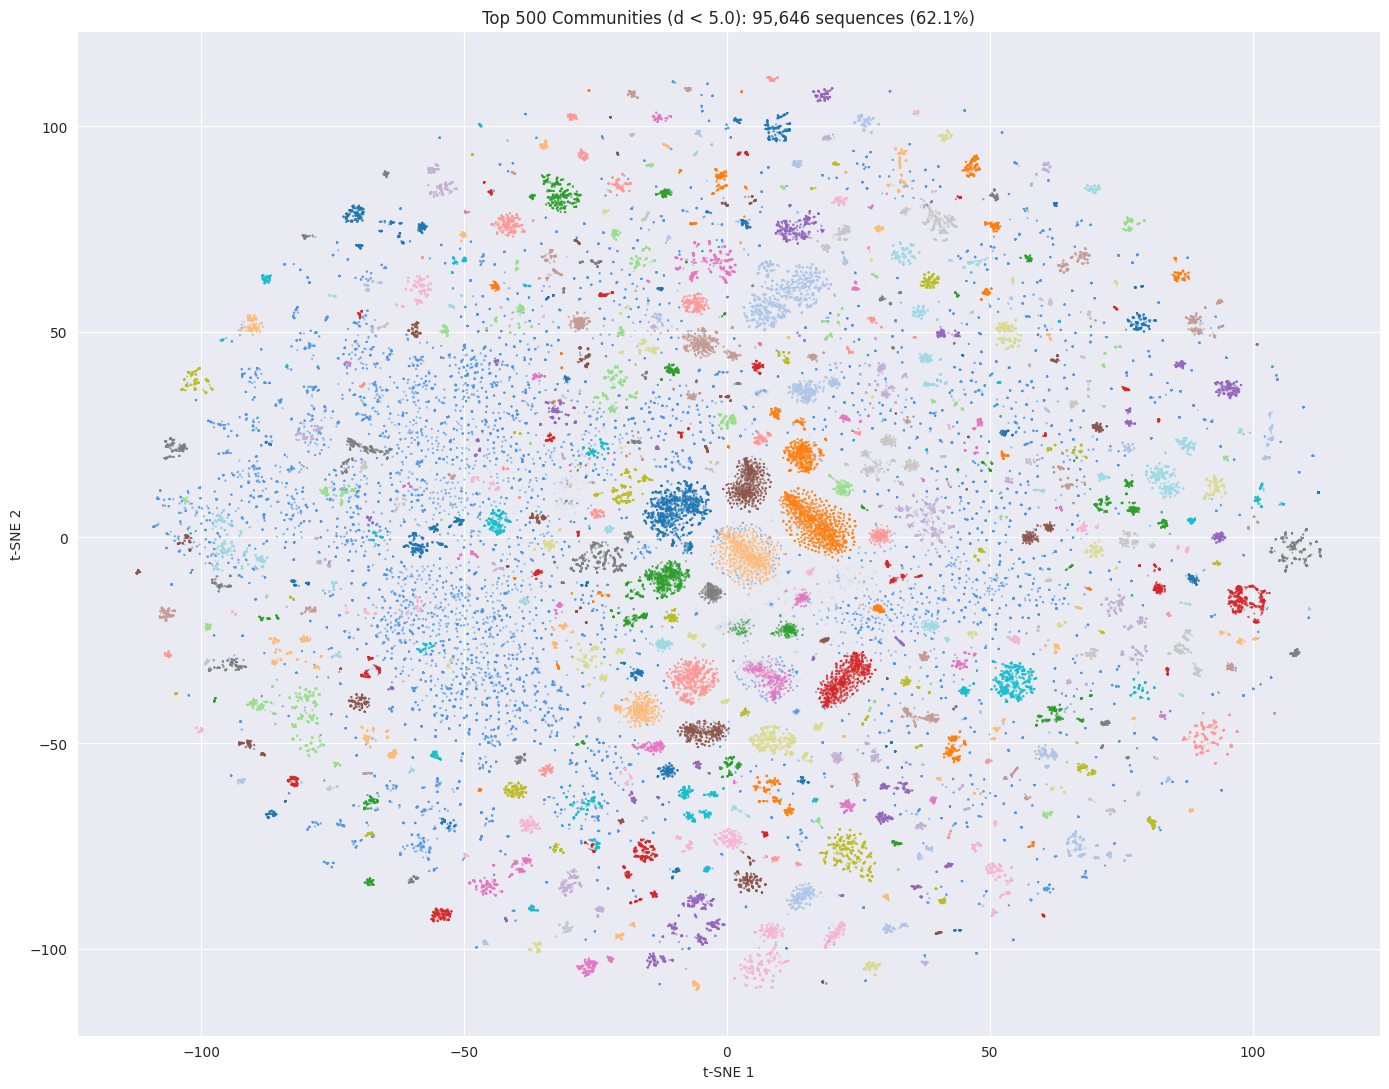

Top 500 communities cover 95,646 sequences (62.1% of total, 71.5% of clustered)
Smallest in top 500: 47


In [28]:
# Visualize top 500 communities on t-SNE
top_n = 500
top_comps_500 = np.argsort(-component_sizes)[:top_n]
# Only keep communities with size > 1
top_comps_500 = top_comps_500[component_sizes[top_comps_500] > 1]

comp_to_rank_500 = np.full(len(component_sizes), -1, dtype = np.int32)
for rank, comp_id in enumerate(top_comps_500):
    comp_to_rank_500[comp_id] = rank
seq_rank_500 = comp_to_rank_500[component_labels]

seq_comp_sizes = component_sizes[component_labels]
is_singleton = seq_comp_sizes == 1

# Use a cycling colormap — spatially separated so reuse is fine
cmap500 = plt.cm.get_cmap('tab20', 20)
colors = np.full((n_sequences, 4), [0.85, 0.85, 0.85, 0.08], dtype = np.float32)

# Non-singleton, outside top 500: light blue
other = (~is_singleton) & (seq_rank_500 == -1)
colors[other] = [0.3, 0.6, 0.9, 0.3]

# Top 500: cycle through 20 colors
for rank in range(len(top_comps_500)):
    mask = seq_rank_500 == rank
    colors[mask] = cmap500(rank % 20)
    colors[mask, 3] = 0.6

fig, ax = plt.subplots(figsize = (14, 11))
ax.scatter(tsne_result[is_singleton, 0], tsne_result[is_singleton, 1],
           c = colors[is_singleton], s = 0.05, rasterized = True)
fg = ~is_singleton
ax.scatter(tsne_result[fg, 0], tsne_result[fg, 1],
           c = colors[fg], s = 0.3, rasterized = True)

n_in_top = sum(component_sizes[c] for c in top_comps_500)
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_title(f'Top {len(top_comps_500)} Communities (d < {d_threshold}): '
             f'{n_in_top:,} sequences ({100 * n_in_top / n_sequences:.1f}%)')
plt.tight_layout()
plt.show()

print(f'Top {len(top_comps_500)} communities cover {n_in_top:,} sequences '
      f'({100 * n_in_top / n_sequences:.1f}% of total, '
      f'{100 * n_in_top / n_clustered:.1f}% of clustered)')
print(f'Smallest in top {len(top_comps_500)}: {component_sizes[top_comps_500[-1]]:,}')

Singletons: 20,161 (median length: 124,950 bp)
Clustered:  133,879 (median length: 166,460 bp)


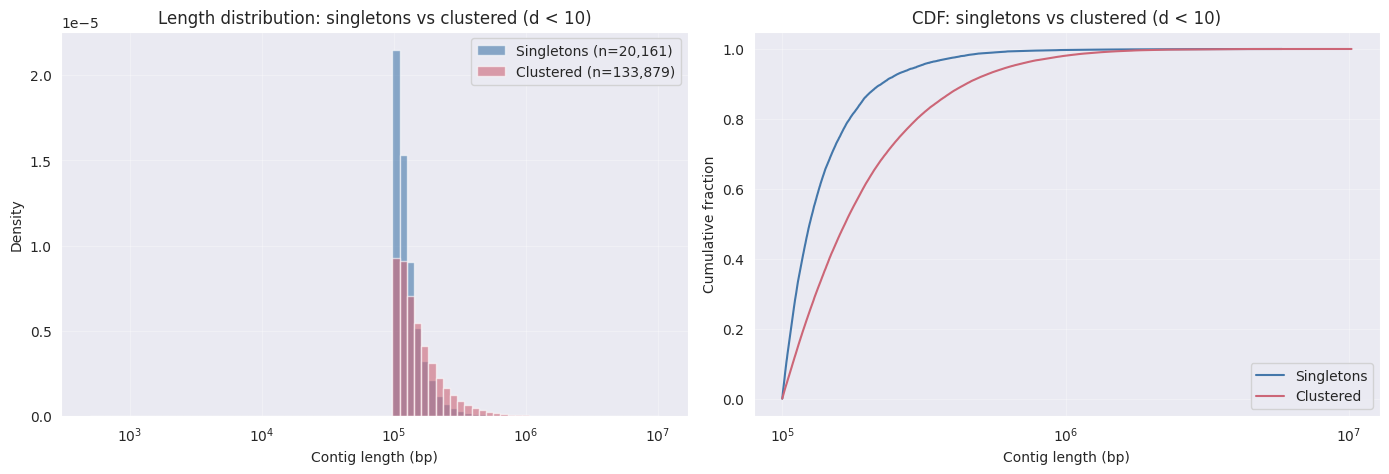

In [29]:
# Length distribution: singletons vs clustered at d < 10
# Uses component_labels and component_sizes from cell 22

seq_community_size = component_sizes[component_labels]
singleton_mask = seq_community_size == 1
clustered_mask = ~singleton_mask

lengths = kmers[:, 0]
singleton_lengths = lengths[singleton_mask]
clustered_lengths = lengths[clustered_mask]

print(f'Singletons: {singleton_mask.sum():,} (median length: {np.median(singleton_lengths):,.0f} bp)')
print(f'Clustered:  {clustered_mask.sum():,} (median length: {np.median(clustered_lengths):,.0f} bp)')

fig, axes = plt.subplots(1, 2, figsize = (14, 5))

# Left: overlapping histograms
bins = np.logspace(np.log10(500), np.log10(lengths.max()), 80)
axes[0].hist(singleton_lengths, bins = bins, alpha = 0.6,
             label = f'Singletons (n={singleton_mask.sum():,})', density = True, color = '#4477AA')
axes[0].hist(clustered_lengths, bins = bins, alpha = 0.6,
             label = f'Clustered (n={clustered_mask.sum():,})', density = True, color = '#CC6677')
axes[0].set_xscale('log')
axes[0].set_xlabel('Contig length (bp)')
axes[0].set_ylabel('Density')
axes[0].set_title('Length distribution: singletons vs clustered (d < 10)')
axes[0].legend()
axes[0].grid(True, alpha = 0.3)

# Right: CDFs
for data, label, color in [
    (singleton_lengths, 'Singletons', '#4477AA'),
    (clustered_lengths, 'Clustered', '#CC6677'),
]:
    sorted_d = np.sort(data)
    cdf = np.arange(1, len(sorted_d) + 1) / len(sorted_d)
    axes[1].plot(sorted_d, cdf, label = label, color = color, linewidth = 1.5)

axes[1].set_xscale('log')
axes[1].set_xlabel('Contig length (bp)')
axes[1].set_ylabel('Cumulative fraction')
axes[1].set_title('CDF: singletons vs clustered (d < 10)')
axes[1].legend()
axes[1].grid(True, alpha = 0.3)

plt.tight_layout()
plt.show()

/tmp/ipykernel_1184984/2103436175.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', 20)


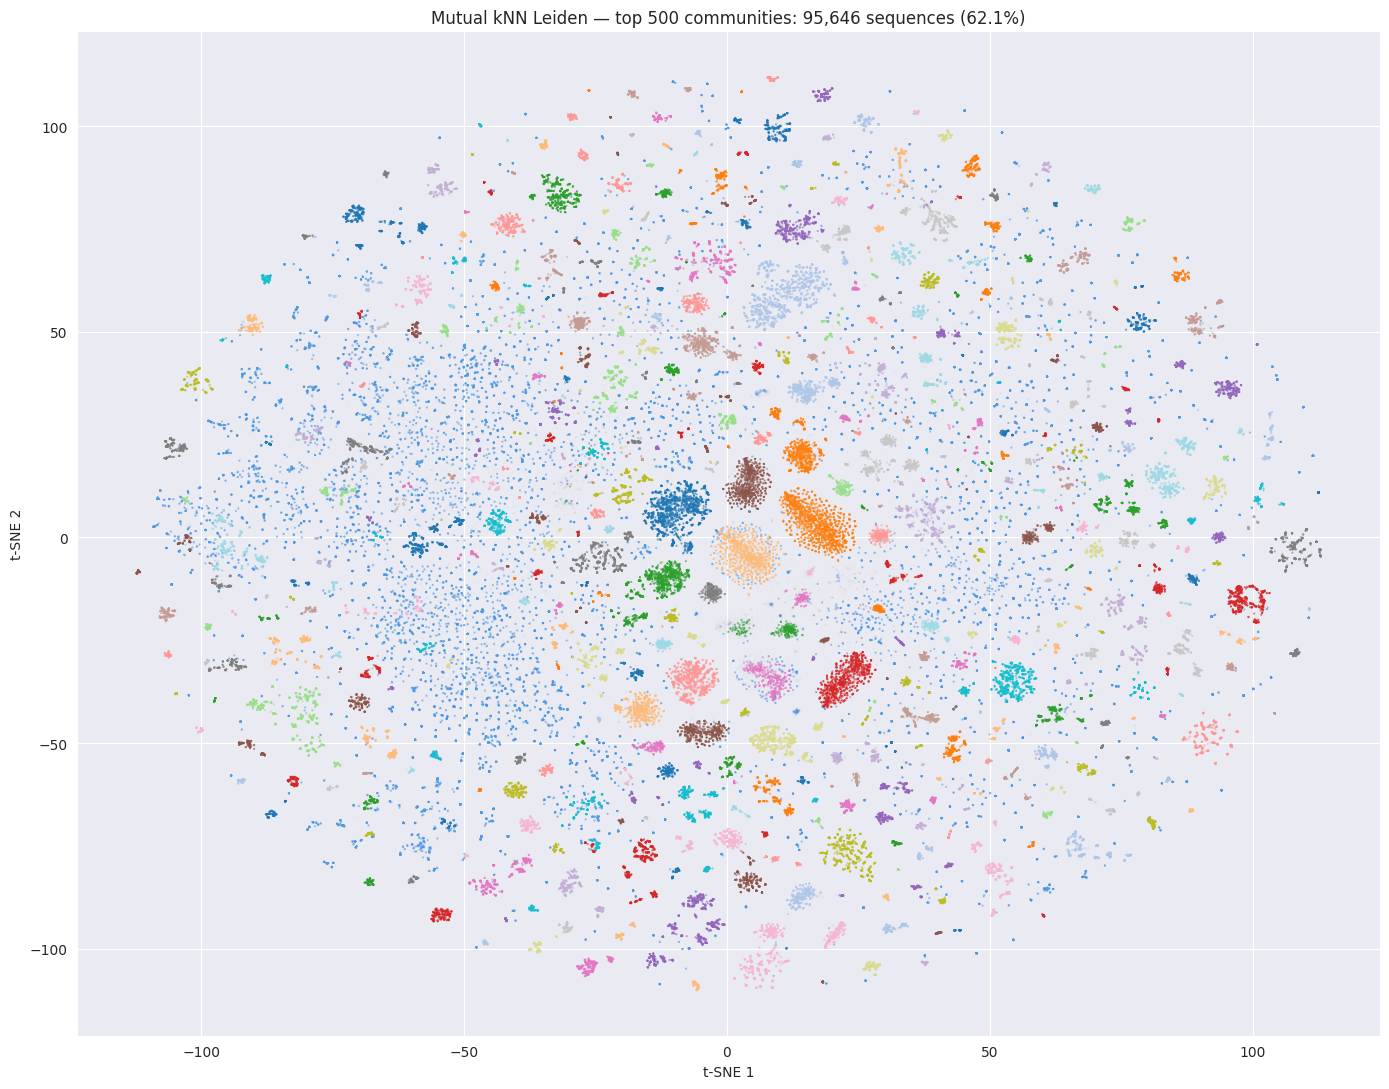

Top 500 communities cover 95,646 sequences (62.1% of total, 71.5% of clustered)
Smallest in top 500: 47


In [30]:
# Overlay mutual kNN Leiden communities on t-SNE
top_n = 500
top_comps = np.argsort(-component_sizes)[:top_n]
top_comps = top_comps[component_sizes[top_comps] > 1]

comp_to_rank = np.full(len(component_sizes), -1, dtype = np.int32)
for rank, comp_id in enumerate(top_comps):
    comp_to_rank[comp_id] = rank
seq_rank = comp_to_rank[component_labels]

seq_comp_sizes = component_sizes[component_labels]
is_singleton = seq_comp_sizes == 1

# Color scheme: grey singletons, light blue other clusters, cycling colors for top N
cmap = plt.cm.get_cmap('tab20', 20)
colors = np.full((n_sequences, 4), [0.85, 0.85, 0.85, 0.08], dtype = np.float32)

# Non-singleton, outside top N: light blue
other = (~is_singleton) & (seq_rank == -1)
colors[other] = [0.3, 0.6, 0.9, 0.3]

# Top N: cycle through 20 colors
for rank in range(len(top_comps)):
    mask = seq_rank == rank
    colors[mask] = cmap(rank % 20)
    colors[mask, 3] = 0.6

fig, ax = plt.subplots(figsize = (14, 11))

# Plot singletons first (background), then clustered (foreground)
ax.scatter(tsne_result[is_singleton, 0], tsne_result[is_singleton, 1],
           c = colors[is_singleton], s = 0.05, rasterized = True)
fg = ~is_singleton
ax.scatter(tsne_result[fg, 0], tsne_result[fg, 1],
           c = colors[fg], s = 0.3, rasterized = True)

n_in_top = sum(component_sizes[c] for c in top_comps)
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_title(f'Mutual kNN Leiden — top {len(top_comps)} communities: '
             f'{n_in_top:,} sequences ({100 * n_in_top / n_sequences:.1f}%)')
plt.tight_layout()
plt.show()

print(f'Top {len(top_comps)} communities cover {n_in_top:,} sequences '
      f'({100 * n_in_top / n_sequences:.1f}% of total, '
      f'{100 * n_in_top / n_clustered:.1f}% of clustered)')
print(f'Smallest in top {len(top_comps)}: {component_sizes[top_comps[-1]]:,}')

In [31]:
# Save in-degree capped graph for MCL (ABC format: nodeA\tnodeB\tweight)
# Re-parses TSV and caps in-degree
from collections import defaultdict

d_threshold = 5.0
epsilon = 0.1
max_in_degree = 100
tsv_path = 'Runs/neighbors_100_NCBI_5.tsv'
n_sequences = len(embeddings)
out_path = 'Runs/graph_capped100_d5_100_NCBI_5.tsv'

id_to_idx = {id_: i for i, id_ in enumerate(embedding_ids)}

# Parse directed edges
print(f'Parsing edges with d < {d_threshold}...')
directed_edges = []
with open(tsv_path, 'r') as f:
    for i, line in enumerate(f):
        fields = line.rstrip('\n').split('\t')
        for field in fields[1:]:
            paren = field.rfind('(')
            dist = float(field[paren + 1:-1])
            if dist >= d_threshold:
                break
            j = id_to_idx[field[:paren]]
            directed_edges.append((i, j, dist))
        if (i + 1) % 1_000_000 == 0:
            print(f'  {i + 1:,} / {n_sequences:,}...')

print(f'Directed edges: {len(directed_edges):,}')

# Cap in-degree
incoming = defaultdict(list)
for i, j, dist in directed_edges:
    incoming[j].append((dist, i))

n_dropped = 0
n_written = 0
with open(out_path, 'w') as f:
    for j, sources in incoming.items():
        if len(sources) > max_in_degree:
            sources.sort()
            n_dropped += len(sources) - max_in_degree
            sources = sources[:max_in_degree]
        for dist, i in sources:
            weight = 1.0 / (dist + epsilon)
            f.write(f'{embedding_ids[i]}\t{embedding_ids[j]}\t{weight:.6f}\n')
            n_written += 1

del directed_edges, incoming

import os
size_mb = os.path.getsize(out_path) / 1e6
print(f'\nEdges dropped by capping: {n_dropped:,}')
print(f'Saved {n_written:,} edges to {out_path} ({size_mb:.1f} MB)')
print(f'Format: source_id<TAB>target_id<TAB>weight (ABC format for MCL)')

Parsing edges with d < 5.0...
Directed edges: 3,987,831

Edges dropped by capping: 437,315
Saved 3,550,516 edges to Runs/graph_capped100_d5_100_NCBI_5.tsv (139.4 MB)
Format: source_id<TAB>target_id<TAB>weight (ABC format for MCL)


In [35]:
# MCL pairwise GC validation across inflation values (100 kbp data, d=5)
# MCL output files: one cluster per line, tab-separated member IDs
rng_val = np.random.default_rng(42)

mcl_dir = 'Runs/MCL_100_NCBI_5_d5'
inflations = [1.4, 2.0, 3.0, 4.0, 5.0, 6.0]

for infl in inflations:
    mcl_file = f'{mcl_dir}/mcl_I{infl}.clusters'
    print(f'{"=" * 70}')
    print(f'MCL I={infl}')
    print(f'{"=" * 70}')

    mcl_clusters = []
    with open(mcl_file) as f:
        for line in f:
            members = line.rstrip('\n').split('\t')
            if len(members) > 1:
                indices = np.array([id_to_idx[m] for m in members])
                mcl_clusters.append(indices)

    mcl_clusters.sort(key = len, reverse = True)
    print(f'Non-singleton clusters: {len(mcl_clusters):,}')
    print(f'Top 5 sizes: {[len(c) for c in mcl_clusters[:5]]}')
    print()

    for rank in range(3):
        comm_idx = mcl_clusters[rank]
        size = len(comm_idx)
        n_sample = min(1000, size)

        if n_sample < size:
            sample_idx = rng_val.choice(comm_idx, size = n_sample, replace = False)
        else:
            sample_idx = comm_idx

        sample_emb = embeddings[sample_idx]
        sq_norms = np.einsum('ij,ij->i', sample_emb, sample_emb)
        sq_dists = sq_norms[:, None] + sq_norms[None, :] - 2 * (sample_emb @ sample_emb.T)
        np.maximum(sq_dists, 0, out = sq_dists)
        np.fill_diagonal(sq_dists, 0)
        d = np.sqrt(sq_dists[np.triu_indices(n_sample, k = 1)])

        gc = one_mers[comm_idx, 1]
        comm_lengths = lengths[comm_idx]

        gc_span = 100 * (gc.max() - gc.min())
        print(f'  Community #{rank + 1} (size {size:,}, sample {n_sample}):')
        print(f'    Distances: mean={d.mean():.2f}, median={np.median(d):.2f}, '
              f'range={d.min():.2f}-{d.max():.2f}')
        print(f'    GC: mean={100 * gc.mean():.1f}%, std={100 * gc.std():.1f}%, '
              f'range={100 * gc.min():.1f}%-{100 * gc.max():.1f}% (span {gc_span:.0f} pp)')
        print(f'    Length: mean={comm_lengths.mean() / 1000:.1f} kbp, '
              f'range={comm_lengths.min() / 1000:.1f}-{comm_lengths.max() / 1000:.1f} kbp')
        print()

        del sq_norms, sq_dists

MCL I=1.4
Non-singleton clusters: 7,142
Top 5 sizes: [967, 850, 848, 845, 742]

  Community #1 (size 967, sample 967):
    Distances: mean=5.58, median=5.61, range=0.83-9.96
    GC: mean=45.9%, std=0.9%, range=41.4%-49.8% (span 8 pp)
    Length: mean=222.1 kbp, range=100.1-1497.0 kbp

  Community #2 (size 850, sample 850):
    Distances: mean=5.63, median=5.65, range=1.42-9.54
    GC: mean=59.1%, std=0.8%, range=55.4%-61.8% (span 6 pp)
    Length: mean=180.3 kbp, range=100.1-923.8 kbp

  Community #3 (size 848, sample 848):
    Distances: mean=5.32, median=5.37, range=0.85-8.42
    GC: mean=29.0%, std=0.9%, range=24.3%-32.9% (span 9 pp)
    Length: mean=196.0 kbp, range=100.0-1148.8 kbp

MCL I=2.0
Non-singleton clusters: 8,879
Top 5 sizes: [345, 335, 307, 291, 289]

  Community #1 (size 345, sample 345):
    Distances: mean=5.27, median=5.30, range=0.29-8.85
    GC: mean=66.1%, std=1.1%, range=61.2%-68.9% (span 8 pp)
    Length: mean=227.0 kbp, range=100.2-2491.1 kbp

  Community #2 (s

Loading full dataset...
Loaded 6,693,829 sequences (384d) in 1.8s
    3 kbp: n= 5,951,176 | mean=12.76  median=12.28 | IQR=[8.12, 17.09] | nn1<5: 9.5% | 143.7s
    5 kbp: n= 4,776,770 | mean=11.43  median=11.17 | IQR=[7.76, 14.99] | nn1<5: 10.0% | 117.0s
   10 kbp: n= 3,039,927 | mean=9.27  median=9.20 | IQR=[6.58, 11.91] | nn1<5: 13.8% | 75.9s
   20 kbp: n= 1,556,556 | mean=7.11  median=7.02 | IQR=[5.02, 8.96] | nn1<5: 24.8% | 39.2s
   50 kbp: n=   461,674 | mean=4.99  median=4.82 | IQR=[3.39, 6.29] | nn1<5: 53.4% | 12.1s
  100 kbp: n=   154,040 | mean=3.58  median=3.38 | IQR=[2.24, 4.56] | nn1<5: 81.6% | 4.2s
  200 kbp: n=    53,138 | mean=2.64  median=2.36 | IQR=[1.55, 3.32] | nn1<5: 92.8% | 1.8s
  500 kbp: n=    11,006 | mean=2.08  median=1.70 | IQR=[1.01, 2.55] | nn1<5: 93.4% | 0.5s


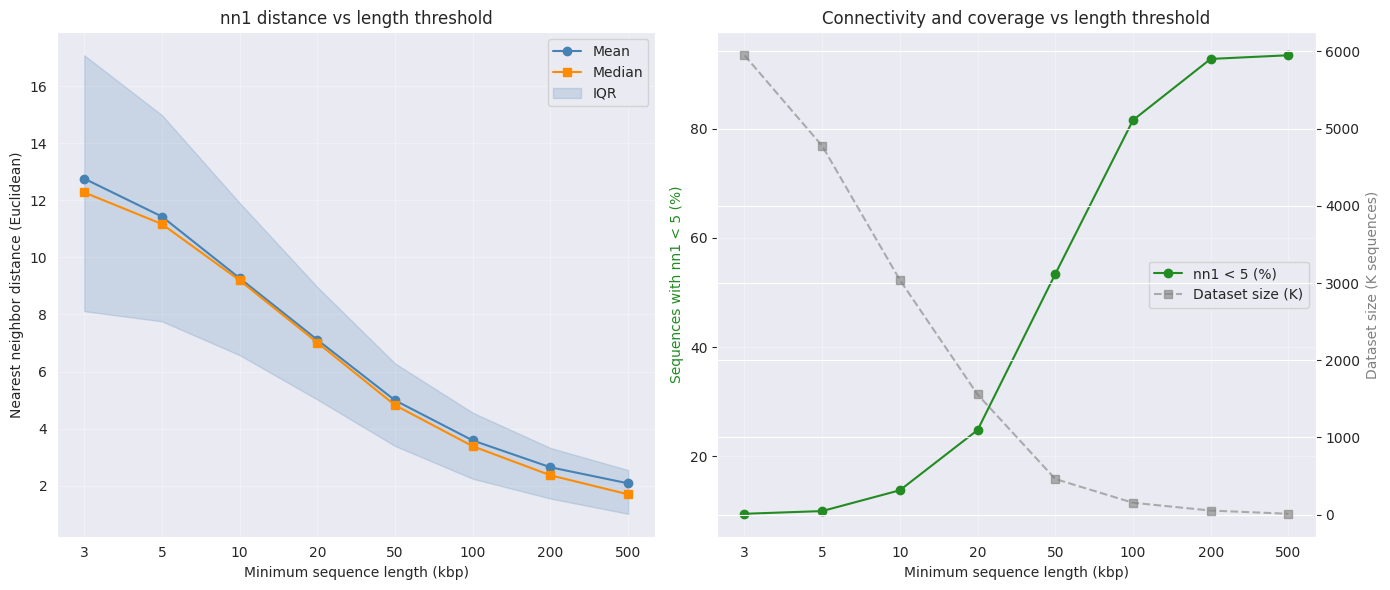


Saved to Runs/nn1_vs_length_threshold.png


In [32]:
# Length threshold sweep: nn1 statistics by minimum sequence length
# Self-contained — loads full dataset independently of earlier cells
import numpy as np
import matplotlib.pyplot as plt
import time

print('Loading full dataset...')
t0 = time.time()
full_data = np.load('Runs/embeddings_SFE_SE_1.npy')
full_lengths = full_data[:, 0]
full_emb = full_data[:, 1:].astype(np.float32)
del full_data
print(f'Loaded {len(full_emb):,} sequences ({full_emb.shape[1]}d) in {time.time() - t0:.1f}s')

thresholds = [3_000, 5_000, 10_000, 20_000, 50_000, 100_000, 200_000, 500_000]
n_queries = 10_000
q_batch = 500
c_batch = 200_000
rng = np.random.default_rng(42)

all_results = []

for thresh in thresholds:
    t0 = time.time()
    indices = np.where(full_lengths >= thresh)[0]
    n = len(indices)

    if n < 100:
        print(f'\n{thresh / 1000:.0f} kbp: {n} sequences — skipping')
        continue

    n_q = min(n_queries, n)
    q_pos = rng.choice(n, size = n_q, replace = False)
    q_global = indices[q_pos]

    min_dists = np.full(n_q, np.inf, dtype = np.float32)

    for qi in range(0, n_q, q_batch):
        qe = min(qi + q_batch, n_q)
        q_emb = full_emb[q_global[qi:qe]]
        q_norms = np.einsum('ij,ij->i', q_emb, q_emb)

        for ci in range(0, n, c_batch):
            ce = min(ci + c_batch, n)
            c_global = indices[ci:ce]
            c_emb = full_emb[c_global]
            c_norms = np.einsum('ij,ij->i', c_emb, c_emb)

            sq_dists = q_norms[:, None] + c_norms[None, :] - 2 * (q_emb @ c_emb.T)
            np.maximum(sq_dists, 0, out = sq_dists)

            # Mask self-distances
            for i in range(qe - qi):
                g = q_global[qi + i]
                local = np.searchsorted(c_global, g)
                if local < len(c_global) and c_global[local] == g:
                    sq_dists[i, local] = np.inf

            chunk_min = np.sqrt(sq_dists.min(axis = 1))
            min_dists[qi:qe] = np.minimum(min_dists[qi:qe], chunk_min)

    elapsed = time.time() - t0

    r = {
        'thresh': thresh,
        'n_total': n,
        'mean': float(min_dists.mean()),
        'median': float(np.median(min_dists)),
        'p25': float(np.percentile(min_dists, 25)),
        'p75': float(np.percentile(min_dists, 75)),
        'frac_lt5': float((min_dists < 5).mean()),
    }
    all_results.append(r)

    print(f'{thresh / 1000:>5.0f} kbp: n={n:>10,} | '
          f'mean={r["mean"]:.2f}  median={r["median"]:.2f} | '
          f'IQR=[{r["p25"]:.2f}, {r["p75"]:.2f}] | '
          f'nn1<5: {r["frac_lt5"]:.1%} | {elapsed:.1f}s')

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize = (14, 6))

labels = [f'{r["thresh"] / 1000:.0f}' for r in all_results]
means = [r['mean'] for r in all_results]
medians = [r['median'] for r in all_results]
p25s = [r['p25'] for r in all_results]
p75s = [r['p75'] for r in all_results]
frac5 = [100 * r['frac_lt5'] for r in all_results]
sizes = [r['n_total'] / 1000 for r in all_results]
x = range(len(labels))

# Left: nn1 distance vs threshold
ax = axes[0]
ax.plot(x, means, 'o-', label = 'Mean', color = 'steelblue')
ax.plot(x, medians, 's-', label = 'Median', color = 'darkorange')
ax.fill_between(x, p25s, p75s, alpha = 0.2, color = 'steelblue', label = 'IQR')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel('Minimum sequence length (kbp)')
ax.set_ylabel('Nearest neighbor distance (Euclidean)')
ax.set_title('nn1 distance vs length threshold')
ax.legend()
ax.grid(True, alpha = 0.3)

# Right: connectivity and coverage
ax = axes[1]
ax2 = ax.twinx()
ln1 = ax.plot(x, frac5, 'o-', label = 'nn1 < 5 (%)', color = 'forestgreen')
ln2 = ax2.plot(x, sizes, 's--', label = 'Dataset size (K)', color = 'gray', alpha = 0.6)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel('Minimum sequence length (kbp)')
ax.set_ylabel('Sequences with nn1 < 5 (%)', color = 'forestgreen')
ax2.set_ylabel('Dataset size (K sequences)', color = 'gray')
ax.set_title('Connectivity and coverage vs length threshold')
lns = ln1 + ln2
ax.legend(lns, [l.get_label() for l in lns], loc = 'center right')
ax.grid(True, alpha = 0.3)

plt.tight_layout()
plt.savefig('Runs/nn1_vs_length_threshold.png', dpi = 150, bbox_inches = 'tight')
plt.show()
print(f'\nSaved to Runs/nn1_vs_length_threshold.png')